<a href="https://colab.research.google.com/github/higorpr/ENEM_Exploration_Analysis/blob/main/ENEM_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methodology

This study aims to deepen the knowledge on data science best practices and follows the methodology presented by professor Carlos Eduardo for data analysis and interpretation. Said methodology can be summerized as:

*Problem Framming > Domain Theory/Hypothesis > Modelling/Engineering > Experiment > Problem Reframming*

The first steps taken will be data preprocessing (e.g., cleanup, duplicate checking) and data exploration.

After these initial steps, it is expected that a "story" can be assembled using data as basis.

# Environment Setup

Cell used for library installation:

In [1]:
!pip install -U -q PyDrive
# !pip install --upgrade xgboost

Cell used for importing libraries:

In [2]:
import pprint
import io
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pprint

from matplotlib.ticker import PercentFormatter
from collections import defaultdict
from random import uniform
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from zipfile import ZipFile

from googleapiclient.http import MediaIoBaseDownload

Getting train and test files from Google Drive:

Obs.: This step needs to be modified for each different Google Drive user.

In [ ]:
file_id = "1-HDq18PMcjLkRnbcLb36kA8dAHy5V55q" #@param {type:"string"}

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

auth.authenticate_user()

drive_service = build('drive', 'v3')

# Replace the assignment below with your file IDn

# to download a different file.
#
# A file ID looks like: 1gLBqEWEBQDYbKCDigHnUXNTkzl-OslSO

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

!unzip {fileId['title']}

data.zip
Archive:  data.zip
  inflating: test.parquet            
  inflating: train.parquet           


Importing train and test files as Pandas Dataframes:

In [ ]:
df_test = pd.read_parquet('test.parquet', engine='pyarrow')
df_train = pd.read_parquet('train.parquet', engine='pyarrow')

Target features to be predicted in a future ML model:

In [ ]:
targets = list(set(df_train.columns) - set(df_test.columns))
print(targets)

['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']


# Data Preprocessing

The sizes of the training and testing dataset are:

In [ ]:
print('Size of test dataset')
df_test.shape[0]

Size of test dataset


1783345

In [ ]:
print('Size of train dataset')
df_train.shape[0]

Size of train dataset


3311925

In [ ]:
df_train.head()

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.0,F,0,1,1,...,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.0,F,1,3,1,...,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.0,M,0,3,1,...,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.0,M,1,1,1,...,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.0,M,1,1,1,...,B,A,A,E,B,B,C,B,B,B


## NaN Values

I'll be working on the train dataset on this phase. Therefore the NaN cleaning process will be focused only on the train dataset at this stage of development.

In [ ]:
# Checking if any rows or collumns are made up of just NaN values:
print('Train dataset shape before check:')
print(df_train.shape)
print('\nChecking if any column is all NaN')
df_train.dropna(axis=1, how='all', inplace=True)
print('Shape after check:')
print(df_train.shape)
print('\nChecking if any row is all NaN')
df_train.dropna(axis=0, how='all', inplace=True)
print('Shape after check:')
print(df_train.shape)

Train dataset shape before check:
(3311925, 118)

Checking if any column is all NaN
Shape after check:
(3311925, 118)

Checking if any row is all NaN
Shape after check:
(3311925, 118)


In [ ]:
# Columns with NaN values
df_train.isna().any()[lambda x: x]

NU_IDADE                   True
CO_MUNICIPIO_NASCIMENTO    True
NO_MUNICIPIO_NASCIMENTO    True
CO_UF_NASCIMENTO           True
SG_UF_NASCIMENTO           True
TP_ENSINO                  True
CO_ESCOLA                  True
CO_MUNICIPIO_ESC           True
NO_MUNICIPIO_ESC           True
CO_UF_ESC                  True
SG_UF_ESC                  True
TP_DEPENDENCIA_ADM_ESC     True
TP_LOCALIZACAO_ESC         True
TP_SIT_FUNC_ESC            True
NU_NOTA_CN                 True
NU_NOTA_CH                 True
NU_NOTA_LC                 True
NU_NOTA_MT                 True
TP_STATUS_REDACAO          True
NU_NOTA_REDACAO            True
dtype: bool

In [ ]:
# Number of NaN values on each column:
df_train.isna().sum()[df_train.isna().sum().values>0]

NU_IDADE                        34
CO_MUNICIPIO_NASCIMENTO      94562
NO_MUNICIPIO_NASCIMENTO      94562
CO_UF_NASCIMENTO             94562
SG_UF_NASCIMENTO             94562
TP_ENSINO                  1441571
CO_ESCOLA                  2566547
CO_MUNICIPIO_ESC           2566547
NO_MUNICIPIO_ESC           2566547
CO_UF_ESC                  2566547
SG_UF_ESC                  2566547
TP_DEPENDENCIA_ADM_ESC     2566547
TP_LOCALIZACAO_ESC         2566547
TP_SIT_FUNC_ESC            2566547
NU_NOTA_CN                  900794
NU_NOTA_CH                  762323
NU_NOTA_LC                  762323
NU_NOTA_MT                  900794
TP_STATUS_REDACAO           762324
NU_NOTA_REDACAO             762324
dtype: int64

Since all the statistics will be based on the target features, these will be investigated first:

In [ ]:
# Checking if NaN values for grades are from people who did not do the test, therefore are not valuable to the statistics
print(df_train['NU_NOTA_CN'].isna().sum() ==  ((df_train['TP_PRESENCA_CN'] == 0) | (df_train['TP_PRESENCA_CN'] == 2)).sum())
print(df_train['NU_NOTA_CH'].isna().sum() ==  ((df_train['TP_PRESENCA_CH'] == 0) | (df_train['TP_PRESENCA_CH'] == 2)).sum())
print(df_train['NU_NOTA_LC'].isna().sum() ==  ((df_train['TP_PRESENCA_LC'] == 0) | (df_train['TP_PRESENCA_LC'] == 2)).sum())
print(df_train['NU_NOTA_MT'].isna().sum() ==  ((df_train['TP_PRESENCA_MT'] == 0) | (df_train['TP_PRESENCA_MT'] == 2)).sum())
print(df_train['NU_NOTA_REDACAO'].isna().sum() == (df_train['TP_STATUS_REDACAO'] != 1).sum()) # '1' in 'TP_STATUS_REDACAO' means that there were no problems with the essay correction.

True
True
True
True
False


For the objective test grades, the number NaN entries match the number of students that did not attend the test or were eliminated from the test for some reason. Therefore these entries will be dropped (considering these entries in the analysis would not make sense in the context how the students conditions play a role in their grades).

In [ ]:
test = df_train.dropna(subset=['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT'],how='any')
print(test.shape[0])
# print(df_train.shape[0] - test.shape[0])
print('Percentage of data dropped by this part of the cleaning process:', round(100-test.shape[0]/df_train.shape[0] * 100,2),'%')
df_train = test.copy()

2405749
Percentage of data dropped by this part of the cleaning process: 27.36 %


The NaN entries for essay grades must be investigated more carefully since there are more options for 'TP_STATUS_REDACAO'.

First, I'll check how many NaN entries are left after cleanup.

In [ ]:
print('NaN entries on the essay grades column:')
print((df_train['NU_NOTA_REDACAO'].isna() == True).sum())
print('\nNaN entries on the essay test status column:')
print((df_train['TP_STATUS_REDACAO'].isna() == True).sum())

NaN entries on the essay grades column:
1

NaN entries on the essay test status column:
1


In [ ]:
# Since the number of NaN entries is 'NU_NOTA_REDACAO' and 'TP_STATUS_REDACAO' are the same, I will check a possible connection between these features' NaNs.
print('Size of dataframe containing rows where "NU_NOTA_REDACAO" or "TP_STATUS_REDACAO" are NaN:')
print(df_train[(df_train['NU_NOTA_REDACAO'].isna() == True) | (df_train['TP_STATUS_REDACAO'].isna() == True)].shape[0])

Size of dataframe containing rows where "NU_NOTA_REDACAO" or "TP_STATUS_REDACAO" are NaN:
1


This check confirms that all the NaN values from 'NU_NOTA_REDACAO' come from NaN entries in 'TP_STATUS_REDACAO'. Therefore, the same NaN cleanup done previously can be applied again.

In [ ]:
df_train.dropna(subset=['NU_NOTA_REDACAO'], how='any', inplace=True)
print('Number of entried in train dataset after grades cleanup:')
print(df_train.shape[0])

Number of entried in train dataset after grades cleanup:
2405748


In [ ]:
# NaN entries on all columns after grades cleanup:
print('Number of NaN entries in each column:\n')
print(df_train.isna().sum()[df_train.isna().sum().values>0])
print('\nPercentage of NaN entries in each column:\n')
round(df_train.isna().sum()[df_train.isna().sum().values>0] / df_train.shape[0] * 100, 4)

Number of NaN entries in each column:

NU_IDADE                        29
CO_MUNICIPIO_NASCIMENTO      69163
NO_MUNICIPIO_NASCIMENTO      69163
CO_UF_NASCIMENTO             69163
SG_UF_NASCIMENTO             69163
TP_ENSINO                  1028337
CO_ESCOLA                  1786126
CO_MUNICIPIO_ESC           1786126
NO_MUNICIPIO_ESC           1786126
CO_UF_ESC                  1786126
SG_UF_ESC                  1786126
TP_DEPENDENCIA_ADM_ESC     1786126
TP_LOCALIZACAO_ESC         1786126
TP_SIT_FUNC_ESC            1786126
dtype: int64

Percentage of NaN entries in each column:



NU_IDADE                    0.0012
CO_MUNICIPIO_NASCIMENTO     2.8749
NO_MUNICIPIO_NASCIMENTO     2.8749
CO_UF_NASCIMENTO            2.8749
SG_UF_NASCIMENTO            2.8749
TP_ENSINO                  42.7450
CO_ESCOLA                  74.2441
CO_MUNICIPIO_ESC           74.2441
NO_MUNICIPIO_ESC           74.2441
CO_UF_ESC                  74.2441
SG_UF_ESC                  74.2441
TP_DEPENDENCIA_ADM_ESC     74.2441
TP_LOCALIZACAO_ESC         74.2441
TP_SIT_FUNC_ESC            74.2441
dtype: float64

From this point on, it would be unwise to just drop the rows with NaN values since the importance of each feature is still unkown when creating a regression model to predict a student's grade.

In [ ]:
# Sending cleaned train dataframe to Google Drive
df_train.to_parquet('df_train.parquet')

with ZipFile('train_data_csv.zip', 'w') as zip_obj:
    zip_obj.write('df_train.parquet')

colab_link = '/content/train_data_csv.zip'
gdrive_link = '/content/drive/MyDrive/Data Science/ENEM/data/'
shutil.copy(colab_link, gdrive_link)

In [ ]:
# Loading cleaned train dataset:

file_id = "1-4kUGL3gM6SCAHvzYTMDQETg275uhtZ_" 

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

auth.authenticate_user()

drive_service = build('drive', 'v3')

# Replace the assignment below with your file IDn

# to download a different file.
#
# A file ID looks like: 1gLBqEWEBQDYbKCDigHnUXNTkzl-OslSO

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

!unzip {fileId['title']}

train_data_csv.zip
Archive:  train_data_csv.zip
 extracting: df_train.parquet        


In [ ]:
df_train = pd.read_parquet('df_train.parquet')
df_train.head()

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.0,F,0,1,1,...,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.0,F,1,3,1,...,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.0,M,0,3,1,...,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.0,M,1,1,1,...,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.0,M,1,1,1,...,B,A,A,E,B,B,C,B,B,B


## Duplicate Data

Search for possible duplicate rows.

In [ ]:
# Number of duplicated rows:
df_train.duplicated().sum()

0

There is not duplicated data in the training dataset.

# Data Exploration

This section dives deeper in the interpretation and statistics of the data after the initial cleanup.

Additionally, some data manipulation can be done if deemed necessary.

## Essay Grade Investigation

Following the data cleaning done in the previous section, it would be useful to know if an essay can receive a grade different than 0 if any issues listed in 'TP_STATUS_REDACAO' are present. That is, if any student got a zero and had a status listed as "No Problems" (TP_STATUS_REDACAO = 1).

What motivated this investigation is the future interpretation of zero-grade essays (if existant).

In [ ]:
# Number of students with zero as grade:
(df_train['NU_NOTA_REDACAO'] == 0).sum()

68815

In [ ]:
# Number of students that got a 0 and had the "no problems" status with the essay:
df_train[(df_train['TP_STATUS_REDACAO'] == 1) & (df_train['NU_NOTA_REDACAO'] == 0)][['TP_STATUS_REDACAO','NU_NOTA_REDACAO']].shape[0]

0

In [ ]:
# Number of students that got a 0 and had some status issue:
df_train[(df_train['TP_STATUS_REDACAO'] != 1) & (df_train['NU_NOTA_REDACAO'] == 0)][['TP_STATUS_REDACAO','NU_NOTA_REDACAO']].shape[0]

68815

In [ ]:
perc = (df_train.shape[0] - (df_train['NU_NOTA_REDACAO'] == 0).sum()) / df_train.shape[0]

print(f'Number of entries in the dataset: {df_train.shape[0]} students.')
print('The number of zero grade essay students is',round((100 - perc*100), 2),'% of the training dataset.')

Number of entries in the dataset: 2405748 students.
The number of zero grade essay students is 2.86 % of the training dataset.


The previous cells showed that a student would only get a zero if its essay had one of the issues listed in "TP_STATUS_REDACAO". 

Considering that students that got a zero on their essays are less than 3% of the dataset, it was decided that these entries would be dropped from the dataset.

They could be considered "pseudo" outliers. Their grades do not reflect their writing prowess since they were given zero as grade for a single mistake rather than as a result of an essay where nothing could be salvaged.

In [ ]:
# Dropping zero essay grades:
df_train = df_train[df_train['NU_NOTA_REDACAO'] != 0]
print(f'Final shape of the training dataset: {df_train.shape}')

Final shape of the training dataset: (2336933, 118)


Saving the latest version of the training dataset:

In [ ]:
# Sending cleaned train dataframe to Google Drive
df_train.to_parquet('df_train_RevA.parquet')

with ZipFile('train_data_parquet_RevA.zip', 'w') as zip_obj:
    zip_obj.write('df_train_RevA.parquet')

colab_link = '/content/train_data_parquet_RevA.zip'
gdrive_link = '/content/drive/MyDrive/Data Science/ENEM/data/'
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Data Science/ENEM/data/train_data_parquet_RevA.zip'

### Latest Dataset Load

Dataset loading cell:

In [3]:
# Loading cleaned train dataset:

file_id = "16ylR6D_Ucf3Ks-eFRkn5CNn-3orosAgk"


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

auth.authenticate_user()

drive_service = build('drive', 'v3')

# Replace the assignment below with your file IDn

# to download a different file.
#
# A file ID looks like: 1gLBqEWEBQDYbKCDigHnUXNTkzl-OslSO

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

!unzip {fileId['title']}

train_data_parquet_RevA.zip
Archive:  train_data_parquet_RevA.zip
 extracting: df_train_RevA.parquet   


In [4]:
df_train = pd.read_parquet('df_train_RevA.parquet')
df_train.head()

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.0,F,0,1,1,...,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.0,F,1,3,1,...,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.0,M,0,3,1,...,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.0,M,1,1,1,...,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.0,M,1,1,1,...,B,A,A,E,B,B,C,B,B,B


Redefining targets:

In [5]:
targets = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']

Checking the data distribution (shape) of the grades:

Text(0.5, 1.0, 'Math grades distribution')

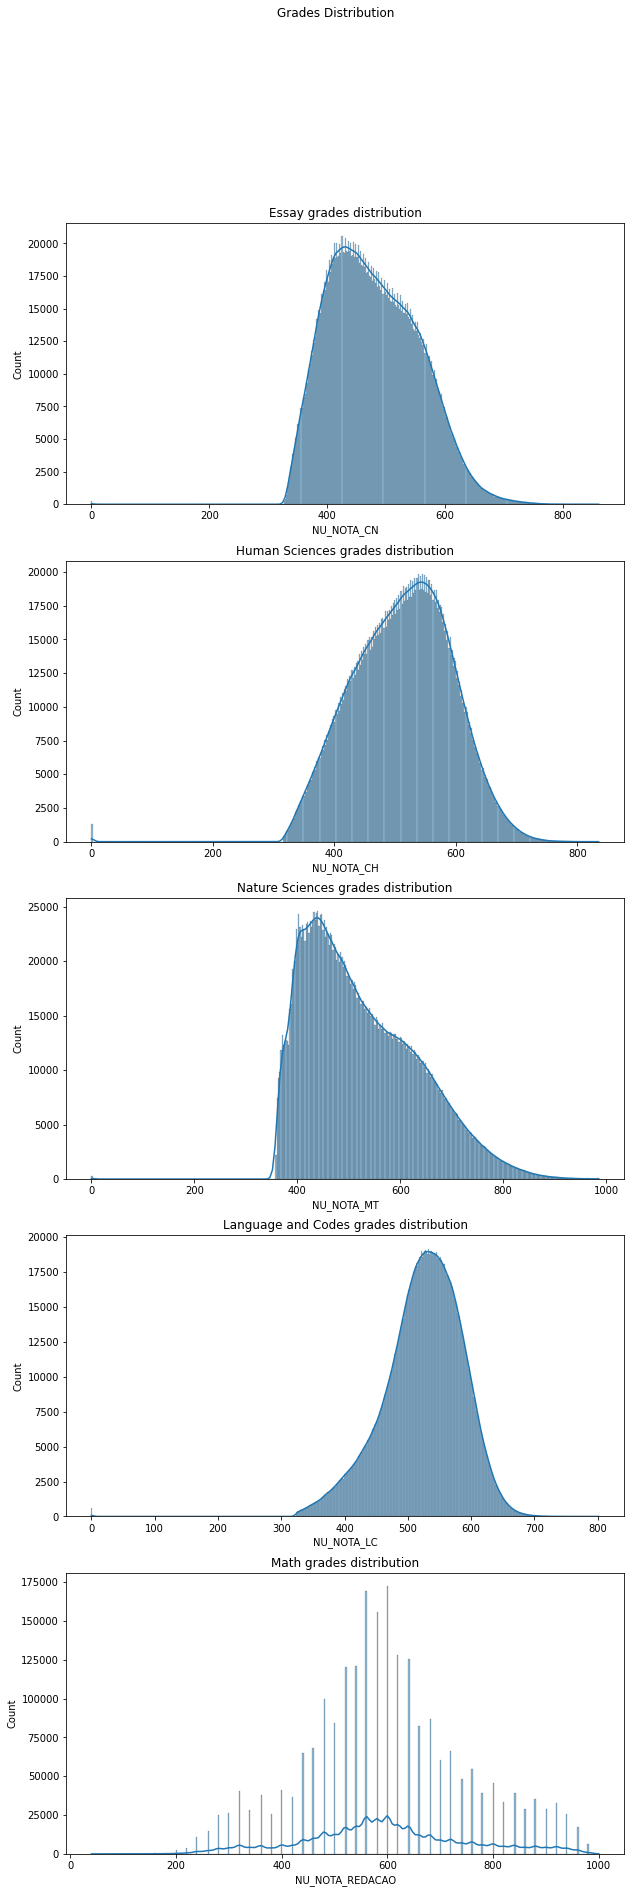

In [6]:
fig, axes = plt.subplots(5, 1, figsize=(10,30))
fig.suptitle('Grades Distribution')

sns.histplot(ax=axes[0],data=df_train[targets[0]], kde=True)
axes[0].set_title('Essay grades distribution')

sns.histplot(ax=axes[1],data=df_train[targets[1]],kde=True)
axes[1].set_title('Human Sciences grades distribution')

sns.histplot(ax=axes[2],data=df_train[targets[2]],kde=True)
axes[2].set_title('Nature Sciences grades distribution')

sns.histplot(ax=axes[3],data=df_train[targets[3]],kde=True)
axes[3].set_title('Language and Codes grades distribution')

sns.histplot(ax=axes[4],data=df_train[targets[4]],kde=True)
axes[4].set_title('Math grades distribution')

## Problem Framming (Exposition)
If you were a Brazilian high school student in 1996 living in the North region of the country and dreamed of going to an university in the Southest region of the country, your life would've been hell. 

Your journey would start by applying each and every university's entry exam (and paying a fee relative to each different application) and praying that two institutions of your interest would not have their exams in the same day.

Since each institution had its own exam, the student would have to be in the university's state to take the exam. Meaning that if you wanted to try the test for UFRJ (in Rio de Janeiro) and USP (in São Paulo), you would have to make two round trips from the North region to one state and than repeat it to the other.

That scenario was pretty common since the most renowed univerities were in the Southestern region of Brazil. So high school students from all over the country were victioms to this system.

Acknowledging the problem, in 1998 the ENEM (High School National Exam) was created and became the main entryway into Brazil's universities. Students would pay one fee and their grade at the exam would serve as means to enter any university in the country. This unified exam was resposible to reduce the handicaps that afflicted many Brazilian students.

The implementation of this exam was a great step to make university admission more democratic and fair. But given Brazil's History and Geography, a students's social-economic, geographic and familiar backgrounds might define its chances to succeed at ENEM.

This is the question I will dive into in this notebook. By using data gathered from a survey answered by ENEM candidates and information about their perfomance at the exam, I will try to understand the influence of external factors in theirs grades. 

From that understanding, I intend to create a regression model in order to predict a student's grades based on external information about it.

## Domain Theory/Hypotheses (Conflict Introduction)
The high level hypothesis is that the grades of an ENEM candidate are, most of times, a factor of social-economic background. It is initially presumed that students comming from wealthier families will often perform considerably better than others coming from poorer families. 

The social-economic discrepancies between regions in Brazil is a well-known issue in the Brazilian society, and like so shall be considered a crucial part of the analysis.

The main hypothesis (high level) can be broken down into more datailed hypotheses (low level):
1. Students living in the wealthiest regions of the country (South and Southest) have a greter chance to do better in the exam. Consequently, students from the poorest regions (North and Northest) have a smaller chance to do well in the exam;
2. Students from the private schooling system have an advantage over students from public schools;
3. The higher the parents' level of education, the better the student's grades;
4. Students with a greater monthly house income have better grades;
5. Internet access is a big factor on the definition of students' grades.

### Hypotheses Checking Preparation - Grade Subdivision



Since all hypotheses presented in the previous section use grades as a metric of students' performance, they will be subdivided into 4 groups in order to facilitate a student's performance.

Ranges in NU_NOTA_CN:
Min Value = 0.0 / Max Value = 860.9000244140625
Ranges in NU_NOTA_CH:
Min Value = 0.0 / Max Value = 835.0999755859375
Ranges in NU_NOTA_MT:
Min Value = 0.0 / Max Value = 985.5
Ranges in NU_NOTA_LC:
Min Value = 0.0 / Max Value = 801.7000122070312
Ranges in NU_NOTA_REDACAO:
Min Value = 40.0 / Max Value = 1000.0


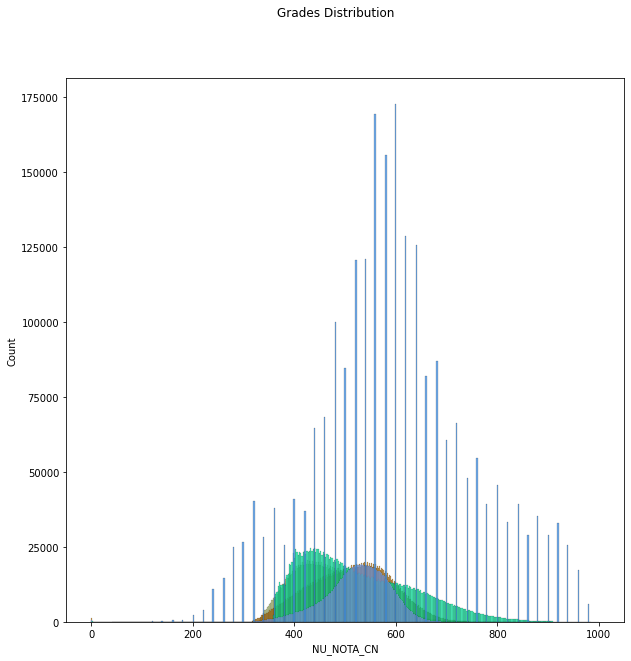

In [ ]:
# Getting grades ranges:
fig, axes = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('Grades Distribution')
for col in targets:
    # Getting min and max values
    max_val = df_train[col].max()
    min_val = df_train[col].min()
    print(f'Ranges in {col}:')
    print(f'Min Value = {min_val} / Max Value = {max_val}')
    # Specifing random color
    r = uniform(0,1)
    g = uniform(0,1)
    b = uniform(0,1)
    color = [r, g, b]
    # Plotting the grades distribution
    sns.histplot(data=df_train[col], color=color)

Since the ranges and distributions vary considerably among grades, I will create the 4 different subdivisions for each grade using percentiles.

- Lower than 25%: very low performance
- Between 25% and 50%: low performance
- Between 50% and 75%: average performance
- Higher than 75%: high performance

#### Creation of Percentiles Dictionary

In [7]:
pp = pprint.PrettyPrinter()

# Dictionary to hold the percentiles for all 5 grades:
perc = {}
# Percentiles of interest
divisions = [25, 50, 75]

for grade in targets: # Iteration over subjects' grades names
    percentiles = [] # List to hold the percentiles
    for div in divisions: # Iteration over the percentiles of interest
        percentiles.append(np.percentile(df_train[grade], div))
    perc[grade] = percentiles
    
pp.pprint(perc)

{'NU_NOTA_CH': [453.6000061035156, 515.7000122070312, 570.0999755859375],
 'NU_NOTA_CN': [419.3999938964844, 472.3999938964844, 534.7999877929688],
 'NU_NOTA_LC': [488.0, 529.4000244140625, 567.7000122070312],
 'NU_NOTA_MT': [436.79998779296875, 503.8999938964844, 600.5999755859375],
 'NU_NOTA_REDACAO': [500.0, 580.0, 680.0]}


### Hypotheses Checking - Hypothesis 1

Hypothesis 1 states that:

*Students living in the wealthiest regions of the country (South and Southest) have a greter chance to do better in the exam. Consequently, students from the poorest regions (North and Northest) have a smaller chance to do well in the exam.*

In order to verify if that statement is true, the features related to the participants' personal information (PPI), information about their high school (HSI) and information about the exam application site ( were compiled.

#### Participant Personal Information (PPI), High School Information (HSI) and Exam Site (ES) Features:

In [12]:
# Creating list with PPI features:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('CO_MUNICIPIO_RESIDENCIA')
last_index = df_train.columns.get_loc('IN_TREINEIRO')
ppi_index = list(range(first_index, last_index + 1))
ppi_index.append(df_train.columns.get_loc(tag_col))
ppi_index = sorted(ppi_index)
ppi = list(df_train.columns[ppi_index])

# Printing PPI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features related to a student's personal information are:\n")
pp.pprint(ppi)
print("\nNumber of features in the PPI section:")
print(len(ppi))

The features related to a student's personal information are:

[   'NU_INSCRICAO',
    'CO_MUNICIPIO_RESIDENCIA',
    'NO_MUNICIPIO_RESIDENCIA',
    'CO_UF_RESIDENCIA',
    'SG_UF_RESIDENCIA',
    'NU_IDADE',
    'TP_SEXO',
    'TP_ESTADO_CIVIL',
    'TP_COR_RACA',
    'TP_NACIONALIDADE',
    'CO_MUNICIPIO_NASCIMENTO',
    'NO_MUNICIPIO_NASCIMENTO',
    'CO_UF_NASCIMENTO',
    'SG_UF_NASCIMENTO',
    'TP_ST_CONCLUSAO',
    'TP_ANO_CONCLUIU',
    'TP_ESCOLA',
    'TP_ENSINO',
    'IN_TREINEIRO']

Number of features in the PPI section:
19


In [13]:
# Creating list with HSI features:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('CO_ESCOLA')
last_index = df_train.columns.get_loc('TP_SIT_FUNC_ESC')
hsi_index = list(range(first_index, last_index + 1))
hsi_index.append(df_train.columns.get_loc(tag_col))
hsi_index = sorted(hsi_index)
hsi = list(df_train.columns[hsi_index])

# Printing HSI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features related to the high school information are:\n")
pp.pprint(hsi)
print("\nNumber of features in the HSI section:")
print(len(hsi))

The features related to the high school information are:

[   'NU_INSCRICAO',
    'CO_ESCOLA',
    'CO_MUNICIPIO_ESC',
    'NO_MUNICIPIO_ESC',
    'CO_UF_ESC',
    'SG_UF_ESC',
    'TP_DEPENDENCIA_ADM_ESC',
    'TP_LOCALIZACAO_ESC',
    'TP_SIT_FUNC_ESC']

Number of features in the HSI section:
9


In [14]:
# Creating list with ES features:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('CO_MUNICIPIO_PROVA')
last_index = df_train.columns.get_loc('SG_UF_PROVA')
es_index = list(range(first_index, last_index + 1))
es_index.append(df_train.columns.get_loc(tag_col))
es_index = sorted(es_index)
es = list(df_train.columns[es_index])

# Printing TSI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features concerning the site where the test is being applied are:\n")
pp.pprint(es)
print("\nNumber of features in this section:")
print(len(es))

The features concerning the site where the test is being applied are:

[   'NU_INSCRICAO',
    'CO_MUNICIPIO_PROVA',
    'NO_MUNICIPIO_PROVA',
    'CO_UF_PROVA',
    'SG_UF_PROVA']

Number of features in this section:
5


In [15]:
df_ppi = df_train[ppi+targets]
df_hsi = df_train[hsi+targets]
df_es = df_train[es+targets]

# These dataframes were created for the data to be managed using smaller datasets.

Check of NaN values percentages remaining in each subsection:

In [ ]:
# PPI Check:
(df_ppi.isna().sum()/df_train.shape[0])*100

NU_INSCRICAO                0.000000
CO_MUNICIPIO_RESIDENCIA     0.000000
NO_MUNICIPIO_RESIDENCIA     0.000000
CO_UF_RESIDENCIA            0.000000
SG_UF_RESIDENCIA            0.000000
NU_IDADE                    0.001241
TP_SEXO                     0.000000
TP_ESTADO_CIVIL             0.000000
TP_COR_RACA                 0.000000
TP_NACIONALIDADE            0.000000
CO_MUNICIPIO_NASCIMENTO     2.841417
NO_MUNICIPIO_NASCIMENTO     2.841417
CO_UF_NASCIMENTO            2.841417
SG_UF_NASCIMENTO            2.841417
TP_ST_CONCLUSAO             0.000000
TP_ANO_CONCLUIU             0.000000
TP_ESCOLA                   0.000000
TP_ENSINO                  42.596472
IN_TREINEIRO                0.000000
NU_NOTA_CN                  0.000000
NU_NOTA_CH                  0.000000
NU_NOTA_MT                  0.000000
NU_NOTA_LC                  0.000000
NU_NOTA_REDACAO             0.000000
dtype: float64

In [ ]:
# HSI Check
(df_hsi.isna().sum() / df_train.shape[0]) * 100

NU_INSCRICAO               0.000000
CO_ESCOLA                 74.391778
CO_MUNICIPIO_ESC          74.391778
NO_MUNICIPIO_ESC          74.391778
CO_UF_ESC                 74.391778
SG_UF_ESC                 74.391778
TP_DEPENDENCIA_ADM_ESC    74.391778
TP_LOCALIZACAO_ESC        74.391778
TP_SIT_FUNC_ESC           74.391778
NU_NOTA_CN                 0.000000
NU_NOTA_CH                 0.000000
NU_NOTA_MT                 0.000000
NU_NOTA_LC                 0.000000
NU_NOTA_REDACAO            0.000000
dtype: float64

In [ ]:
# ES Check:
(df_es.isna().sum() / df_train.shape[0]) * 100

NU_INSCRICAO          0.0
CO_MUNICIPIO_PROVA    0.0
NO_MUNICIPIO_PROVA    0.0
CO_UF_PROVA           0.0
SG_UF_PROVA           0.0
NU_NOTA_CN            0.0
NU_NOTA_CH            0.0
NU_NOTA_MT            0.0
NU_NOTA_LC            0.0
NU_NOTA_REDACAO       0.0
dtype: float64

Ideally, Hypothesis 1 would be checked using SG_UF_ESC (Abbreviation for school's state), but only around 25.6% of this feature is not NaN.

To circumvent that lack of data, two other features could be used: CO_UF_NASCIMENTO (student's state of birth) or SG_UF_PROVA (state where the exam took place). 

The hypothesis that a student would take the exam on the same state of their high school (SG_UF_PROVA == SG_UF_ESC) is more credible than the hypothesis that a student would not move from the state they were born (SG_UF_NASCIMENTO == SG_UF_ESC). That being said, SG_UF_PROVA will be used to check hypothesis 1.

#### Hypothesis 1 - Visualization

In [8]:
# Creating list for all Brazilian regions
SE = ['RJ', 'SP', 'ES', 'MG']
S = ['SC', 'PR', 'RS']
NE = ['MA', 'PI', 'RN', 'CE', 'PB', 'BA', 'PB', 'AL', 'SE']
N = ['AM', 'AC', 'RO', 'RR', 'AP', 'PA', 'TO']
CW = ['DF', 'GO', 'MT', 'MS']
regions = {'SE':SE, 'S':S, 'NE':NE, 'N':N, 'CW':CW}

In [16]:
# Getting values for plot:
hg = defaultdict(dict) # High Grades
ag = defaultdict(dict) # Average Grades
lg = defaultdict(dict) # Low Grades
vlg = defaultdict(dict) # Very Low Grades

for grade in targets:
    for region, states in regions.items():
        n_high = df_es[(df_es['SG_UF_PROVA'].isin(states)) & (df_es[grade] > perc[grade][2])].shape[0]
        n_average = df_es[(df_es['SG_UF_PROVA'].isin(states)) & (df_es[grade] <= perc[grade][2]) & (df_es[grade] > perc[grade][1])].shape[0]
        n_low = df_es[(df_es['SG_UF_PROVA'].isin(states)) & (df_es[grade] <= perc[grade][1]) & (df_es[grade] > perc[grade][0])].shape[0]
        n_very_low =df_es[(df_es['SG_UF_PROVA'].isin(states)) & (df_es[grade] <= perc[grade][0])].shape[0]
        total = n_high + n_average + n_low + n_very_low

        hg[region][grade] = round((n_high / total) * 100 , 2) 
        ag[region][grade] = round((n_average / total) * 100, 2) 
        lg[region][grade] = round((n_low / total) * 100, 2) 
        vlg[region][grade] = round((n_very_low / total) * 100, 2) 

In [17]:
# Cretion of data dictionary:
geo_data = defaultdict(dict)

# Creation of plot heights
for region in regions:
    for grade in targets:
        geo_data[region][grade] = [hg[region][grade], ag[region][grade], lg[region][grade], vlg[region][grade]]

Text(0.5, 1.0, 'Math Test Performance')

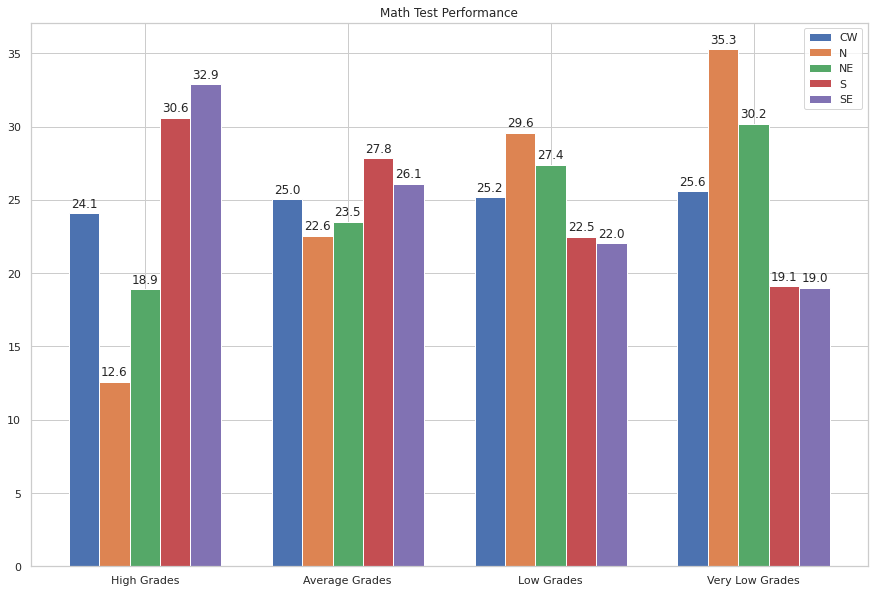

In [22]:
# Math Plot:
labels = ['High Grades', 'Average Grades', 'Low Grades', 'Very Low Grades']
sns.set_theme()
sns.set_style("whitegrid")

x = 1.5 * np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_cw = ax.bar(x - 2*width, geo_data['CW']['NU_NOTA_MT'], width, label='CW')
rects_n = ax.bar(x - width, geo_data['N']['NU_NOTA_MT'], width, label='N')
rects_ne = ax.bar(x , geo_data['NE']['NU_NOTA_MT'], width, label='NE')
rects_s = ax.bar(x + width, geo_data['S']['NU_NOTA_MT'], width, label='S')
rects_se = ax.bar(x + 2*width, geo_data['SE']['NU_NOTA_MT'], width, label='SE')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each Brazilian Region')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_cw)
autolabel(rects_n)
autolabel(rects_ne)
autolabel(rects_s)
autolabel(rects_se)

plt.title("Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Math Exam")

Text(0.5, 1.0, 'Languages Test Performance')

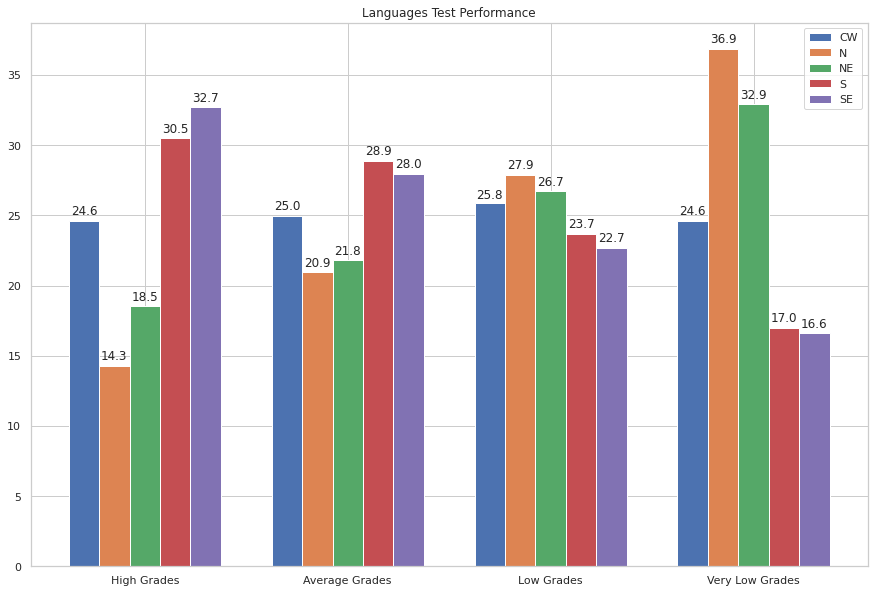

In [21]:
# Plot for Languages:
labels = ['High Grades', 'Average Grades', 'Low Grades', 'Very Low Grades']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_cw = ax.bar(x - 2*width, geo_data['CW']['NU_NOTA_LC'], width, label='CW')
rects_n = ax.bar(x - width, geo_data['N']['NU_NOTA_LC'], width, label='N')
rects_ne = ax.bar(x , geo_data['NE']['NU_NOTA_LC'], width, label='NE')
rects_s = ax.bar(x + width, geo_data['S']['NU_NOTA_LC'], width, label='S')
rects_se = ax.bar(x + 2*width, geo_data['SE']['NU_NOTA_LC'], width, label='SE')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each Brazilian Region')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_cw)
autolabel(rects_n)
autolabel(rects_ne)
autolabel(rects_s)
autolabel(rects_se)

plt.title("Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Languages Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Human Sciences Exam')

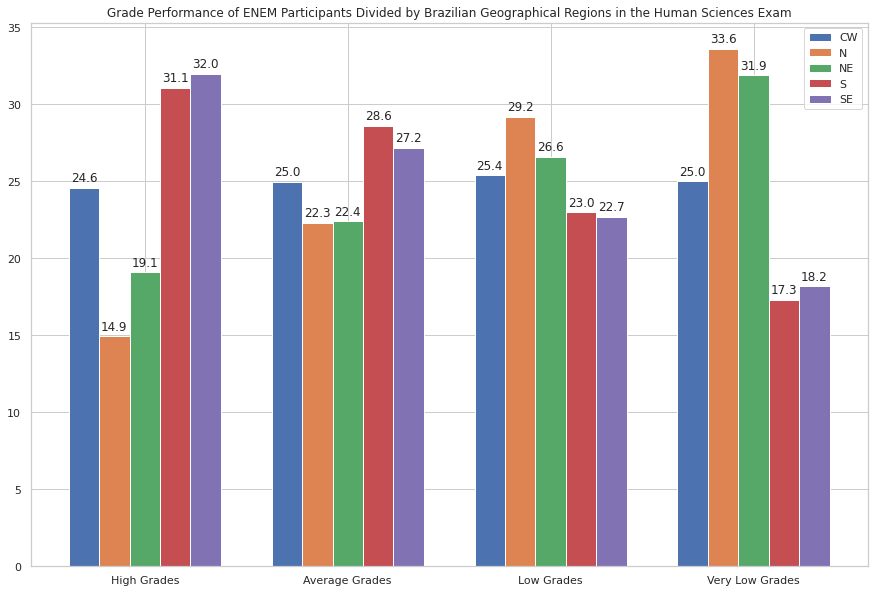

In [34]:
# Human Sciences:
labels = ['High Grades', 'Average Grades', 'Low Grades', 'Very Low Grades']
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_cw = ax.bar(x - 2*width, geo_data['CW']['NU_NOTA_CH'], width, label='CW')
rects_n = ax.bar(x - width, geo_data['N']['NU_NOTA_CH'], width, label='N')
rects_ne = ax.bar(x , geo_data['NE']['NU_NOTA_CH'], width, label='NE')
rects_s = ax.bar(x + width, geo_data['S']['NU_NOTA_CH'], width, label='S')
rects_se = ax.bar(x + 2*width, geo_data['SE']['NU_NOTA_CH'], width, label='SE')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each Brazilian Region')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_cw)
autolabel(rects_n)
autolabel(rects_ne)
autolabel(rects_s)
autolabel(rects_se)

plt.title("Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Human Sciences Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Natural Sciences Exam')

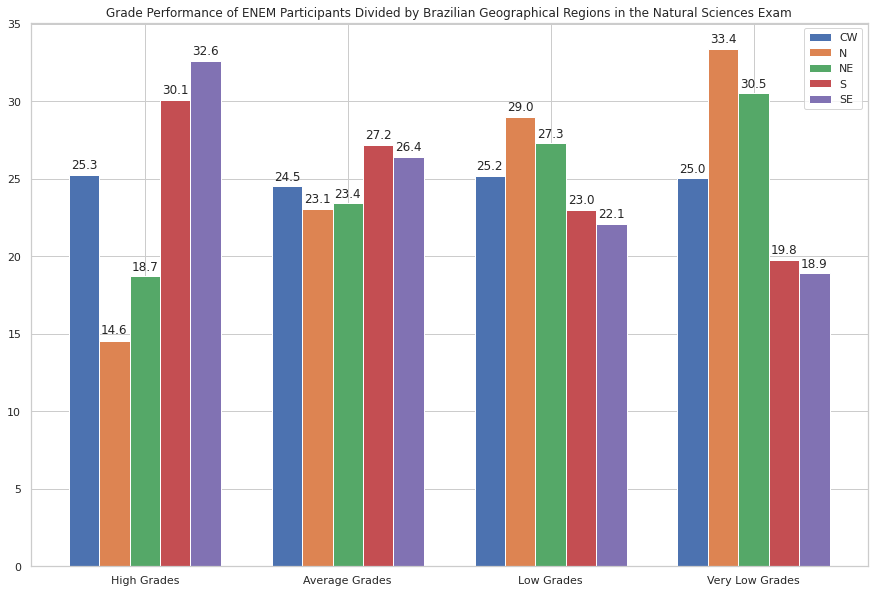

In [35]:
# Natural Sciences:
labels = ['High Grades', 'Average Grades', 'Low Grades', 'Very Low Grades']
# sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_cw = ax.bar(x - 2*width, geo_data['CW']['NU_NOTA_CN'], width, label='CW')
rects_n = ax.bar(x - width, geo_data['N']['NU_NOTA_CN'], width, label='N')
rects_ne = ax.bar(x , geo_data['NE']['NU_NOTA_CN'], width, label='NE')
rects_s = ax.bar(x + width, geo_data['S']['NU_NOTA_CN'], width, label='S')
rects_se = ax.bar(x + 2*width, geo_data['SE']['NU_NOTA_CN'], width, label='SE')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each Brazilian Region')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_cw)
autolabel(rects_n)
autolabel(rects_ne)
autolabel(rects_s)
autolabel(rects_se)

plt.title("Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Natural Sciences Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Essay Exam')

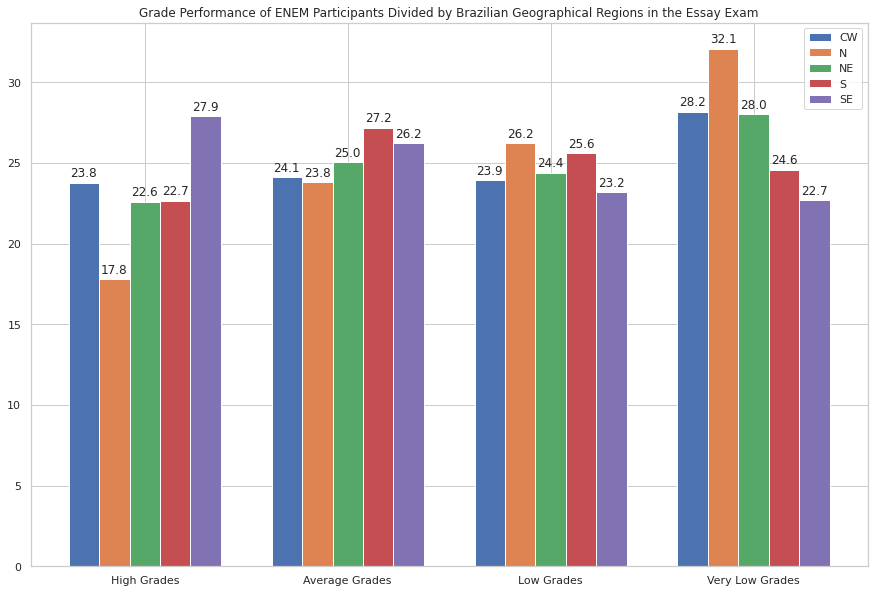

In [36]:
# Essays:
labels = ['High Grades', 'Average Grades', 'Low Grades', 'Very Low Grades']
# sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_cw = ax.bar(x - 2*width, geo_data['CW']['NU_NOTA_REDACAO'], width, label='CW')
rects_n = ax.bar(x - width, geo_data['N']['NU_NOTA_REDACAO'], width, label='N')
rects_ne = ax.bar(x , geo_data['NE']['NU_NOTA_REDACAO'], width, label='NE')
rects_s = ax.bar(x + width, geo_data['S']['NU_NOTA_REDACAO'], width, label='S')
rects_se = ax.bar(x + 2*width, geo_data['SE']['NU_NOTA_REDACAO'], width, label='SE')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each Brazilian Region')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_cw)
autolabel(rects_n)
autolabel(rects_ne)
autolabel(rects_s)
autolabel(rects_se)

plt.title("Grade Performance of ENEM Participants Divided by Brazilian Geographical Regions in the Essay Exam")

#### Hypothesis 1 - Summary

Analyzing the previous plots, the result for Hypothesis 1 was:

- Math: Hypothesis confirmed 
- Languages: Hypothesis confirmed
- Human Sciences: Hypothesis confirmed
- Nature Sciences: Hypothesis confirmed
- Essay: Hypothesis refuted (The variations in percentages did not follow a descendent or ascendent trend for the target regions)

Obs 1 : the Center-West region had a similar distribuition throughout all grade performances for all subjects (the essays had a slight spike in very low grades).

Obs.2: As expected, the best performing region was the Southest region. This expectation was due to its status as the wealthiest region in the country.

Obs.3: The worst performing region was the North region, and one of the factors that explains this is the wealth argument used in the previous observation: the North region gathers the most number of the poor towns in Brazil.

### Hypotheses Checking - Hypothesis 2

Hypothesis 2 states that:

*Students from the private schooling system have an advantage over students from public schools;*

The feature used to check this hypothesis is TP_ESCOLA, which is in the PPI section of the data. 

Despite this feature not having NaN values,it has a "did not respond" option. So the first step is to check the percentage of data with this option.

In [37]:
no_response = df_ppi[df_ppi['TP_ESCOLA'] == 1].shape[0]/df_ppi.shape[0]
print(f'{round(no_response * 100,1)}% of students did not inform to which type of school they attended.')

67.3% of students did not inform to which type of school they attended.


Since the percentage for "no response" students is quite high, one possible option to work with this data is using bootstrapping to infer on the whole dataset based on 32.7% of the complete data.

But first, it is important to check how the data distribution of this remaining usable data (check for unreal data distributions, e.g. 99% of students coming from private schools).

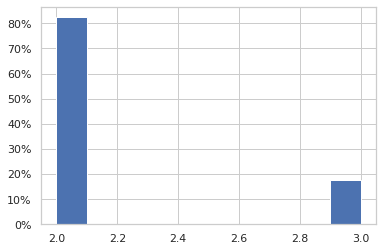

In [68]:
df_hs = df_ppi[df_ppi['TP_ESCOLA'] != 1]
data = df_hs['TP_ESCOLA']

sns.set_style("whitegrid")
plt.hist(data, weights=np.ones(len(data)) / len(data))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()
sns.set_theme()
sns.set_style("whitegrid")

This histogram informs that around 80% of students come from public schools and approximately 20% of students come from private schools, which are not absurd percentages given Brazilian social inequity. With that, I feel confident in bootstrap sampling this dataset.

#### Hypothesis 2 - Sample Bootstrapping

In [39]:
df_resp = df_ppi[df_ppi['TP_ESCOLA'] != 1]
n_trials = int(1e3)

hg = defaultdict(dict)
avg = defaultdict(dict)
low = defaultdict(dict)
vlow = defaultdict(dict)
total = defaultdict(dict)

s_types = [2,3] # "2" = public / 3 = private

for grade in targets:
    for s_type in s_types:
        hg[grade][s_type] = []
        avg[grade][s_type] = []
        low[grade][s_type] = []
        vlow[grade][s_type] = []
        total[s_type] = []

for trial in range(n_trials):
    df_sample = df_resp.sample(n=df_resp.shape[0],replace=True)

    for grade in targets:
        for s_type in s_types:
            total[s_type] = df_sample[df_sample['TP_ESCOLA'] == s_type].shape[0]
            hg[grade][s_type].append(df_sample[(df_sample['TP_ESCOLA'] == s_type) & (df_sample[grade] > perc[grade][2])].shape[0] / total[s_type])
            avg[grade][s_type].append(df_sample[(df_sample['TP_ESCOLA'] == s_type) & (df_sample[grade] <= perc[grade][2]) & (df_sample[grade] > perc[grade][1])].shape[0] / total[s_type])
            low[grade][s_type].append(df_sample[(df_sample['TP_ESCOLA'] == s_type) & (df_sample[grade] <= perc[grade][1]) & (df_sample[grade] > perc[grade][0])].shape[0] / total[s_type])
            vlow[grade][s_type].append(df_sample[(df_sample['TP_ESCOLA'] == s_type) & (df_sample[grade] <= perc[grade][0])].shape[0] / total[s_type])
            

Obs.: The first number of iterations attempted was 10^5. But since it took too long to run (process stopped at around 1 hour), the iterations were reduced to 10^3.

In [40]:
# Getting the averages:
avg_hg = defaultdict(dict)
avg_avg = defaultdict(dict)
avg_low = defaultdict(dict)
avg_vlow = defaultdict(dict)

for grade in targets:
    for s_type in s_types:
        if s_type == 2:
            avg_hg[grade]['public'] = np.array(hg[grade][s_type]).mean()
            avg_avg[grade]['public'] = np.array(avg[grade][s_type]).mean()
            avg_low[grade]['public'] = np.array(low[grade][s_type]).mean()
            avg_vlow[grade]['public'] = np.array(vlow[grade][s_type]).mean()
            
        else:
            avg_hg[grade]['private'] = np.array(hg[grade][s_type]).mean()
            avg_avg[grade]['private'] = np.array(avg[grade][s_type]).mean()
            avg_low[grade]['private'] = np.array(low[grade][s_type]).mean()
            avg_vlow[grade]['private'] = np.array(vlow[grade][s_type]).mean()

#### Hypothesis 2 - Visualization

Following the same logic applied to the previous hypothesis:

In [41]:
# Creation of school type data dictionary:        
st_data = defaultdict(dict)

# Creation of plot heights
for st in ['public', 'private']:
    for grade in targets:
        st_data[st][grade] = [ round(avg_hg[grade][st] * 100, 2), round(avg_avg[grade][st] * 100, 2), round(avg_low[grade][st] * 100, 2), round(avg_vlow[grade][st] * 100, 2) ] 

st_data

defaultdict(dict,
            {'private': {'NU_NOTA_CH': [55.9, 23.28, 12.52, 8.3],
              'NU_NOTA_CN': [58.98, 21.87, 11.19, 7.95],
              'NU_NOTA_LC': [55.41, 23.98, 12.75, 7.87],
              'NU_NOTA_MT': [58.59, 22.31, 11.9, 7.2],
              'NU_NOTA_REDACAO': [59.06, 23.25, 11.33, 6.36]},
             'public': {'NU_NOTA_CH': [16.53, 25.17, 28.34, 29.96],
              'NU_NOTA_CN': [16.7, 24.73, 27.94, 30.62],
              'NU_NOTA_LC': [17.04, 24.57, 27.79, 30.6],
              'NU_NOTA_MT': [17.98, 26.04, 28.45, 27.53],
              'NU_NOTA_REDACAO': [19.57, 25.96, 25.14, 29.34]}})

Text(0.5, 1.0, 'Grade Performance of ENEM Participants from Private and Public Schools in the Math Exam')

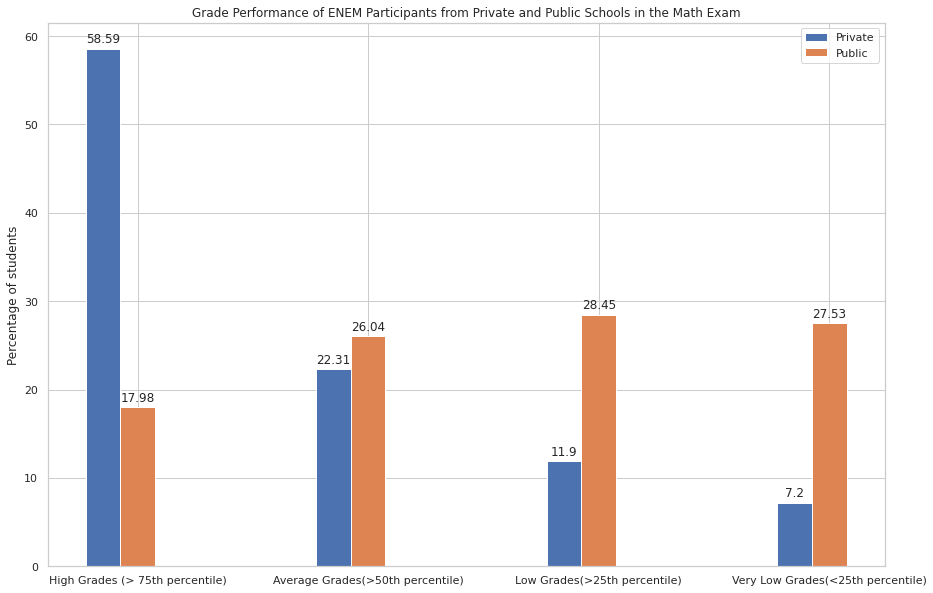

In [42]:
# Math Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_priv = ax.bar(x - width, st_data['private']['NU_NOTA_MT'], width, label='Private')
rects_pub = ax.bar(x , st_data['public']['NU_NOTA_MT'], width, label='Public')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each school category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_priv)
autolabel(rects_pub)


plt.title('Grade Performance of ENEM Participants from Private and Public Schools in the Math Exam')

Text(0.5, 1.0, 'Grade Performance of ENEM Participants from Private and Public Schools in the Languages Exam')

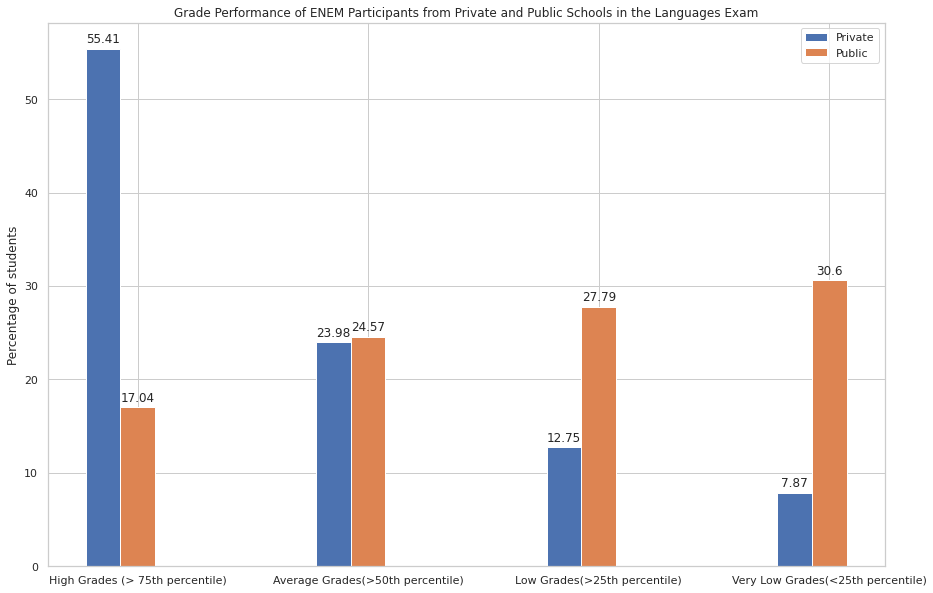

In [43]:
# Languages Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_priv = ax.bar(x - width, st_data['private']['NU_NOTA_LC'], width, label='Private')
rects_pub = ax.bar(x , st_data['public']['NU_NOTA_LC'], width, label='Public')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each school category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_priv)
autolabel(rects_pub)

plt.title('Grade Performance of ENEM Participants from Private and Public Schools in the Languages Exam')

Text(0.5, 1.0, 'Grade Performance of ENEM Participants from Private and Public Schools in the Human Sciences Exam')

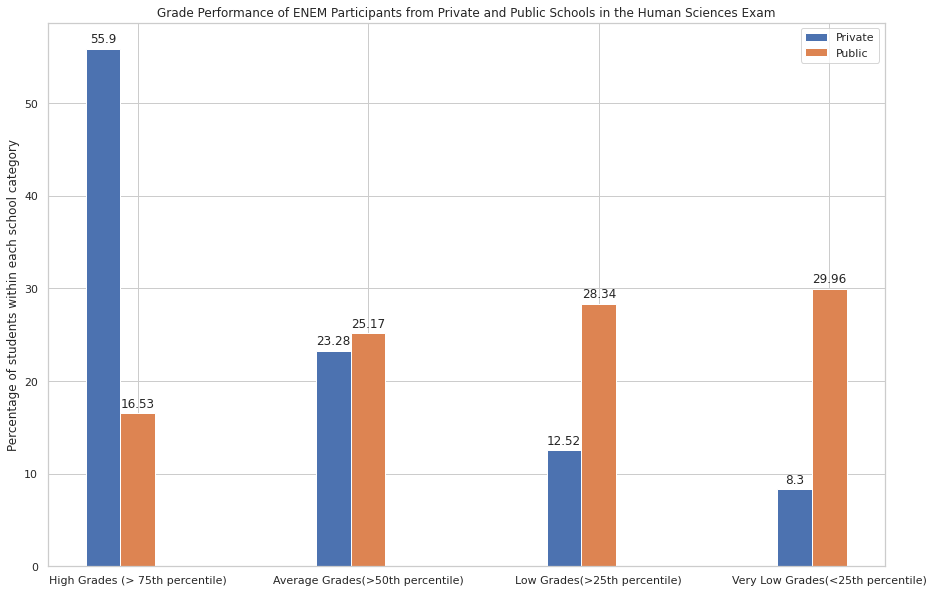

In [64]:
# Human Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_priv = ax.bar(x - width, st_data['private']['NU_NOTA_CH'], width, label='Private')
rects_pub = ax.bar(x , st_data['public']['NU_NOTA_CH'], width, label='Public')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each school category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_priv)
autolabel(rects_pub)


plt.title('Grade Performance of ENEM Participants from Private and Public Schools in the Human Sciences Exam')

Text(0.5, 1.0, 'Grade Performance of ENEM Participants from Private and Public Schools in the Nature Sciences Exam')

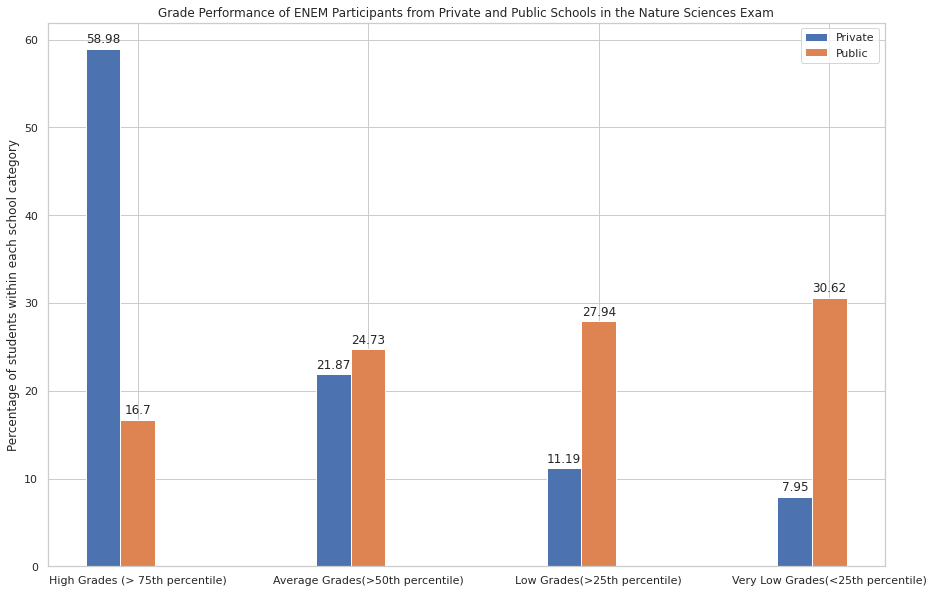

In [65]:
# Nature Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_priv = ax.bar(x - width, st_data['private']['NU_NOTA_CN'], width, label='Private')
rects_pub = ax.bar(x , st_data['public']['NU_NOTA_CN'], width, label='Public')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each school category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_priv)
autolabel(rects_pub)


plt.title('Grade Performance of ENEM Participants from Private and Public Schools in the Nature Sciences Exam')

Text(0.5, 1.0, 'Grade Performance of ENEM Participants from Private and Public Schools in the Essay Exam')

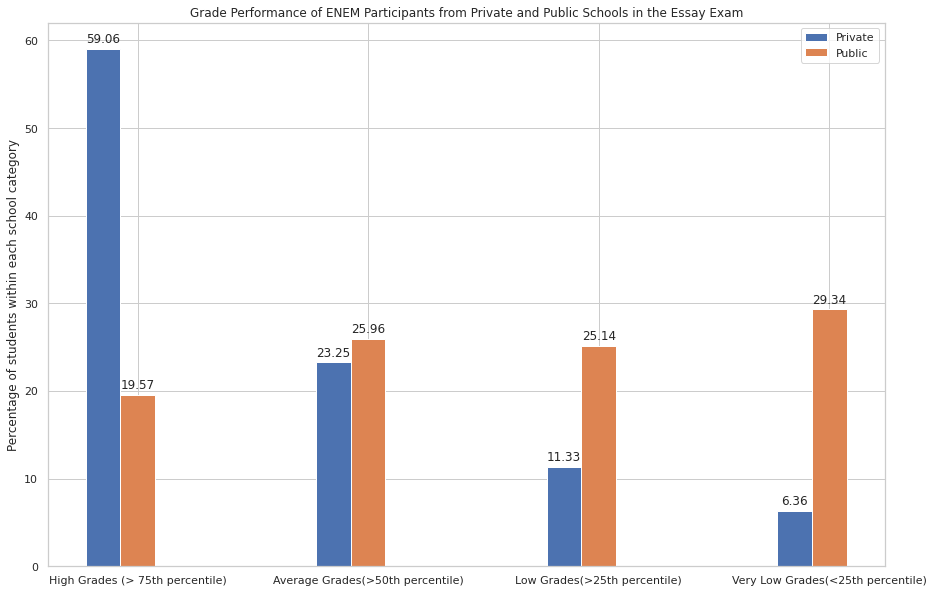

In [66]:
# Essay Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects_priv = ax.bar(x - width, st_data['private']['NU_NOTA_REDACAO'], width, label='Private')
rects_pub = ax.bar(x , st_data['public']['NU_NOTA_REDACAO'], width, label='Public')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each school category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_priv)
autolabel(rects_pub)


plt.title('Grade Performance of ENEM Participants from Private and Public Schools in the Essay Exam')

#### Hypothesis 2 - Summary 

Analyzing the previous plots regarding Hypothesis 2, some key points can be highlighted:

- Hypothesis 2 is confirmed for all subjects in the ENEM exam, especially when the extremes (high and very low grades) are taken into consideration.
- As a rule, public schools have a lower percentage of students in the high grades category. But the other categories percentage values are really close.
- Students from private schools have a considerable high percentage on high grades (almost 60%) and a considerable low percentage in very low grades (between 6 and 8%) following a stair-like pattern for all subjects. 
- These results, despite being interesting, might not be useful in the creation of a prediction model due to the amount of missing data in this feature in the training dataset.

### Hypotheses Checking - Hypothesis 3

Hypothesis 3 states that:

*The higher the parents' level of education, the better the student's grades*

This hypothesis is based mainly on features Q001 and Q022 (Parents' education level).



In [46]:
# Check the percentage of students that answered Q001 or Q002 as "I don't know":
df_father = df_train[(df_train['Q001'] == 'H') & (df_train['Q002'] != 'H')]
df_mother = df_train[(df_train['Q002'] == 'H') & (df_train['Q001'] != 'H')]
df_father_mother =  df_train[(df_train['Q001'] == 'H') & (df_train['Q002'] == 'H')]
print('IDK_Father', round((df_father.shape[0]/df_train.shape[0])*100, 2))
print('IDK_Mother', round((df_mother.shape[0]/df_train.shape[0])*100, 2))
print('IDK_Father_Mother', round((df_father_mother.shape[0]/df_train.shape[0])*100, 2))
total = round((df_father.shape[0] + df_mother.shape[0] + df_father_mother.shape[0]) *100 / df_train.shape[0], 2)
print(f'\nPercentage of students that did not inform at least one of their parents level of education:', total)

IDK_Father 6.37
IDK_Mother 0.78
IDK_Father_Mother 1.77

Percentage of students that did not inform at least one of their parents level of education: 8.92


Given the detailed nature of these features (the education level range from "did not study" until "completed post-graduation studies"), more information cannot be infered from other features without introducing biases in the analysis. Therefore I will consider a 9% loss of data as acceptable.

Additionally, I will also check the grades of students that answered "I don't know".

Before starting to process data, it is important to mention that the criteria for defining the parents' education level is to consider the parent with the highest education level. E.g., if a father never studied and a mother completed university studies, the student will be classified as having parents with university degrees.

#### Hypothesis 3 - Visualization

In [44]:
# Getting ed. levels variables in the features:
ed_levels = sorted(list(df_train['Q001'].unique()))

# Creating the dictionaries to hold the percentages of students in each grade range
hg_ed = defaultdict(dict) # High Grades
ag_ed = defaultdict(dict) # Average Grades
lg_ed = defaultdict(dict) # Low Grades
vg_ed = defaultdict(dict) # Very Low Grades

# Students divided by grade performance in all subjects and parents' education level:
for lvl in ed_levels:
    for grade in targets:
        fathers_only = df_train[df_train['Q001'] == lvl] # Students with fathers on det. ed. level
        mothers_only = df_train[df_train['Q002'] == lvl] # Students with mothers on det. ed. level
        fathers_mothers = df_train[(df_train['Q001'] == lvl) & (df_train['Q002'] == lvl)] # Students with fathers and monthers on det. ed. level
        total = fathers_only.shape[0] + mothers_only.shape[0] + fathers_mothers.shape[0] # Total number of students with at least one parent on det. ed. levels

        # Getting the percentages of students in each grade category:
        hg_ed[lvl][grade] = (fathers_only[fathers_only[grade] > perc[grade][2]].shape[0] + mothers_only[mothers_only[grade] > perc[grade][2]].shape[0] + 
                             fathers_mothers[fathers_mothers[grade] > perc[grade][2]].shape[0]) / total

        ag_ed[lvl][grade] = (fathers_only[(fathers_only[grade] > perc[grade][1]) & (fathers_only[grade] <= perc[grade][2])].shape[0] + 
                             mothers_only[(mothers_only[grade] > perc[grade][1]) & (mothers_only[grade] <= perc[grade][2])].shape[0] +
                             fathers_mothers[(fathers_mothers[grade] > perc[grade][1]) & (fathers_mothers[grade] <= perc[grade][2])].shape[0]) / total

        lg_ed[lvl][grade] = (fathers_only[(fathers_only[grade] > perc[grade][0]) & (fathers_only[grade] <= perc[grade][1])].shape[0] + 
                             mothers_only[(mothers_only[grade] > perc[grade][0]) & (mothers_only[grade] <= perc[grade][1])].shape[0] +
                             fathers_mothers[(fathers_mothers[grade] > perc[grade][0]) & (fathers_mothers[grade] <= perc[grade][1])].shape[0]) / total

        vg_ed[lvl][grade] = (fathers_only[fathers_only[grade] <= perc[grade][0]].shape[0] + mothers_only[mothers_only[grade] <= perc[grade][0]].shape[0] + 
                             fathers_mothers[fathers_mothers[grade] <= perc[grade][0]].shape[0]) / total

In [45]:
# Creation of school type data dictionary:        
ed_lvl_data = defaultdict(dict)

# Creation of plot heights
for lvl in ed_levels:
    for grade in targets:
        ed_lvl_data[lvl][grade] = [ round(hg_ed[lvl][grade] * 100, 2), round(ag_ed[lvl][grade] * 100, 2), round(lg_ed[lvl][grade] * 100, 2), round(vg_ed[lvl][grade] * 100, 2) ] 

ed_lvl_data

defaultdict(dict,
            {'A': {'NU_NOTA_CH': [8.65, 19.99, 30.8, 40.55],
              'NU_NOTA_CN': [7.34, 21.32, 32.29, 39.05],
              'NU_NOTA_LC': [6.93, 16.83, 29.64, 46.6],
              'NU_NOTA_MT': [6.76, 18.26, 30.13, 44.85],
              'NU_NOTA_REDACAO': [8.43, 19.57, 27.87, 44.13]},
             'B': {'NU_NOTA_CH': [12.72, 23.4, 29.9, 33.97],
              'NU_NOTA_CN': [11.63, 24.28, 30.73, 33.36],
              'NU_NOTA_LC': [11.41, 22.06, 30.34, 36.19],
              'NU_NOTA_MT': [11.47, 22.92, 30.02, 35.59],
              'NU_NOTA_REDACAO': [12.48, 23.37, 28.23, 35.92]},
             'C': {'NU_NOTA_CH': [16.93, 25.01, 28.43, 29.64],
              'NU_NOTA_CN': [16.28, 25.55, 28.59, 29.59],
              'NU_NOTA_LC': [16.32, 24.85, 28.54, 30.28],
              'NU_NOTA_MT': [16.57, 25.49, 28.46, 29.48],
              'NU_NOTA_REDACAO': [16.91, 25.26, 26.93, 30.89]},
             'D': {'NU_NOTA_CH': [19.28, 25.8, 27.51, 27.41],
              'NU_NOTA_CN'

Text(0.5, 1.0, "Grade Performance of ENEM Participants Divided by Parents' Education Level in the Math Exam")

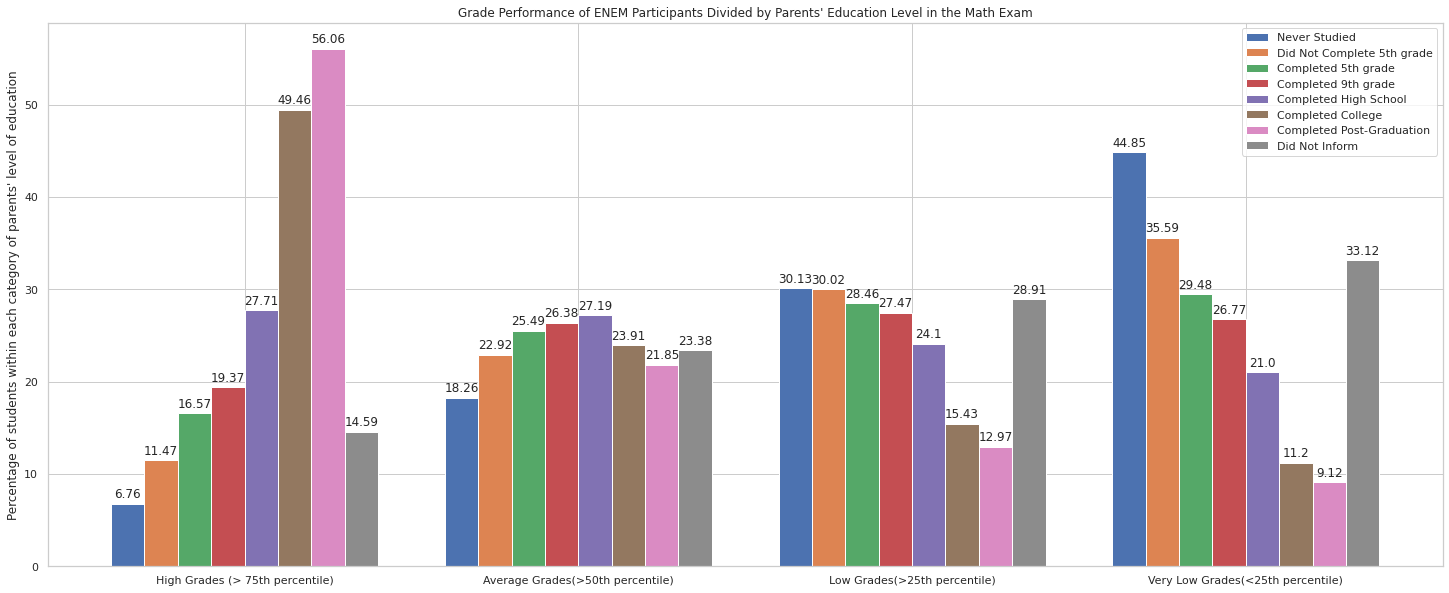

In [73]:
# Math Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1.5*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_a = ax.bar(x - 3.5 * width, ed_lvl_data['A']['NU_NOTA_MT'], width, label='Never Studied')
rects_b = ax.bar(x - 2.5 * width, ed_lvl_data['B']['NU_NOTA_MT'], width, label='Did Not Complete 5th grade')
rects_c = ax.bar(x - 1.5 * width, ed_lvl_data['C']['NU_NOTA_MT'], width, label='Completed 5th grade')
rects_d = ax.bar(x - 0.5 * width, ed_lvl_data['D']['NU_NOTA_MT'], width, label='Completed 9th grade')
rects_e = ax.bar(x + 0.5 * width, ed_lvl_data['E']['NU_NOTA_MT'], width, label='Completed High School')
rects_f = ax.bar(x + 1.5 * width, ed_lvl_data['F']['NU_NOTA_MT'], width, label='Completed College')
rects_g = ax.bar(x + 2.5 * width, ed_lvl_data['G']['NU_NOTA_MT'], width, label='Completed Post-Graduation')
rects_h = ax.bar(x + 3.5 * width, ed_lvl_data['H']['NU_NOTA_MT'], width, label='Did Not Inform')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel("Percentage of students within each category of parents' level of education")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_a)
autolabel(rects_b)
autolabel(rects_c)
autolabel(rects_d)
autolabel(rects_e)
autolabel(rects_f)
autolabel(rects_g)
autolabel(rects_h)


plt.title("Grade Performance of ENEM Participants Divided by Parents' Education Level in the Math Exam")

Text(0.5, 1.0, "Grade Performance of ENEM Participants Divided by Parents' Education Level in the Languages Exam")

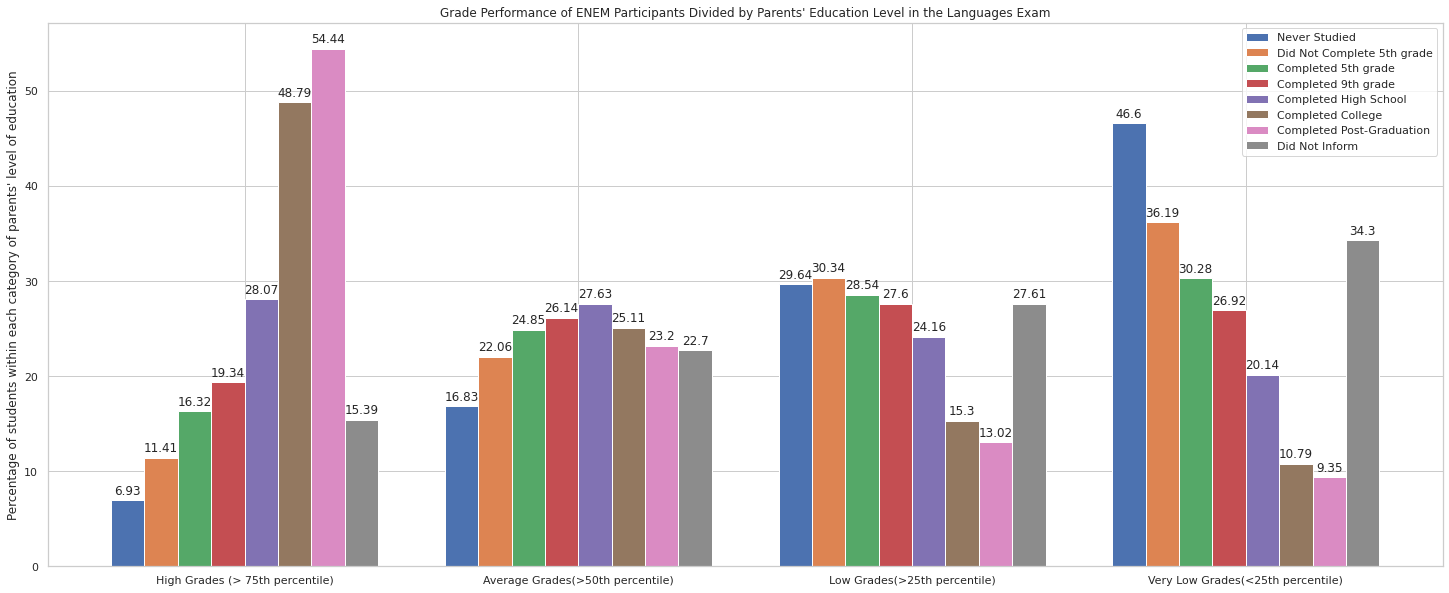

In [72]:
# Languages Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1.5*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_a = ax.bar(x - 3.5 * width, ed_lvl_data['A']['NU_NOTA_LC'], width, label='Never Studied')
rects_b = ax.bar(x - 2.5 * width, ed_lvl_data['B']['NU_NOTA_LC'], width, label='Did Not Complete 5th grade')
rects_c = ax.bar(x - 1.5 * width, ed_lvl_data['C']['NU_NOTA_LC'], width, label='Completed 5th grade')
rects_d = ax.bar(x - 0.5 * width, ed_lvl_data['D']['NU_NOTA_LC'], width, label='Completed 9th grade')
rects_e = ax.bar(x + 0.5 * width, ed_lvl_data['E']['NU_NOTA_LC'], width, label='Completed High School')
rects_f = ax.bar(x + 1.5 * width, ed_lvl_data['F']['NU_NOTA_LC'], width, label='Completed College')
rects_g = ax.bar(x + 2.5 * width, ed_lvl_data['G']['NU_NOTA_LC'], width, label='Completed Post-Graduation')
rects_h = ax.bar(x + 3.5 * width, ed_lvl_data['H']['NU_NOTA_LC'], width, label='Did Not Inform')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel("Percentage of students within each category of parents' level of education")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_a)
autolabel(rects_b)
autolabel(rects_c)
autolabel(rects_d)
autolabel(rects_e)
autolabel(rects_f)
autolabel(rects_g)
autolabel(rects_h)


plt.title("Grade Performance of ENEM Participants Divided by Parents' Education Level in the Languages Exam")

Text(0.5, 1.0, "Grade Performance of ENEM Participants Divided by Parents' Education Level in the Human Sciences Exam")

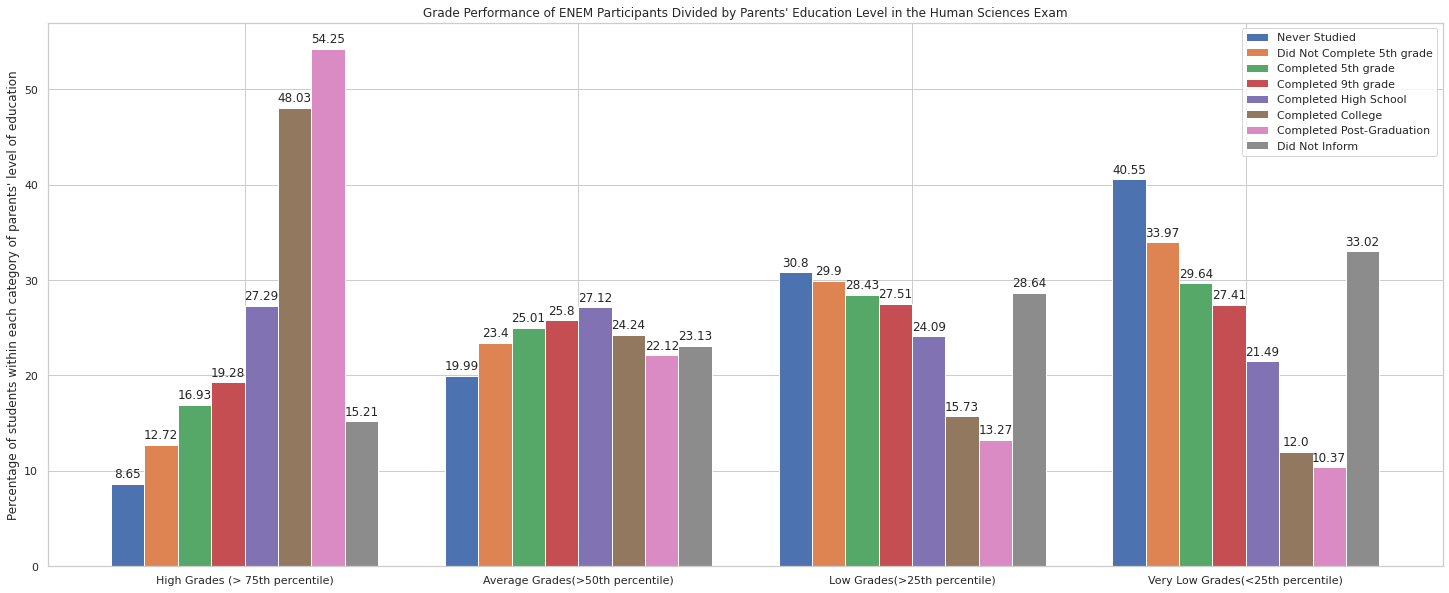

In [71]:
# Human Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1.5*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_a = ax.bar(x - 3.5 * width, ed_lvl_data['A']['NU_NOTA_CH'], width, label='Never Studied')
rects_b = ax.bar(x - 2.5 * width, ed_lvl_data['B']['NU_NOTA_CH'], width, label='Did Not Complete 5th grade')
rects_c = ax.bar(x - 1.5 * width, ed_lvl_data['C']['NU_NOTA_CH'], width, label='Completed 5th grade')
rects_d = ax.bar(x - 0.5 * width, ed_lvl_data['D']['NU_NOTA_CH'], width, label='Completed 9th grade')
rects_e = ax.bar(x + 0.5 * width, ed_lvl_data['E']['NU_NOTA_CH'], width, label='Completed High School')
rects_f = ax.bar(x + 1.5 * width, ed_lvl_data['F']['NU_NOTA_CH'], width, label='Completed College')
rects_g = ax.bar(x + 2.5 * width, ed_lvl_data['G']['NU_NOTA_CH'], width, label='Completed Post-Graduation')
rects_h = ax.bar(x + 3.5 * width, ed_lvl_data['H']['NU_NOTA_CH'], width, label='Did Not Inform')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel("Percentage of students within each category of parents' level of education")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_a)
autolabel(rects_b)
autolabel(rects_c)
autolabel(rects_d)
autolabel(rects_e)
autolabel(rects_f)
autolabel(rects_g)
autolabel(rects_h)


plt.title("Grade Performance of ENEM Participants Divided by Parents' Education Level in the Human Sciences Exam")

Text(0.5, 1.0, "Grade Performance of ENEM Participants Divided by Parents' Education Level in the Nature Sciences Exam")

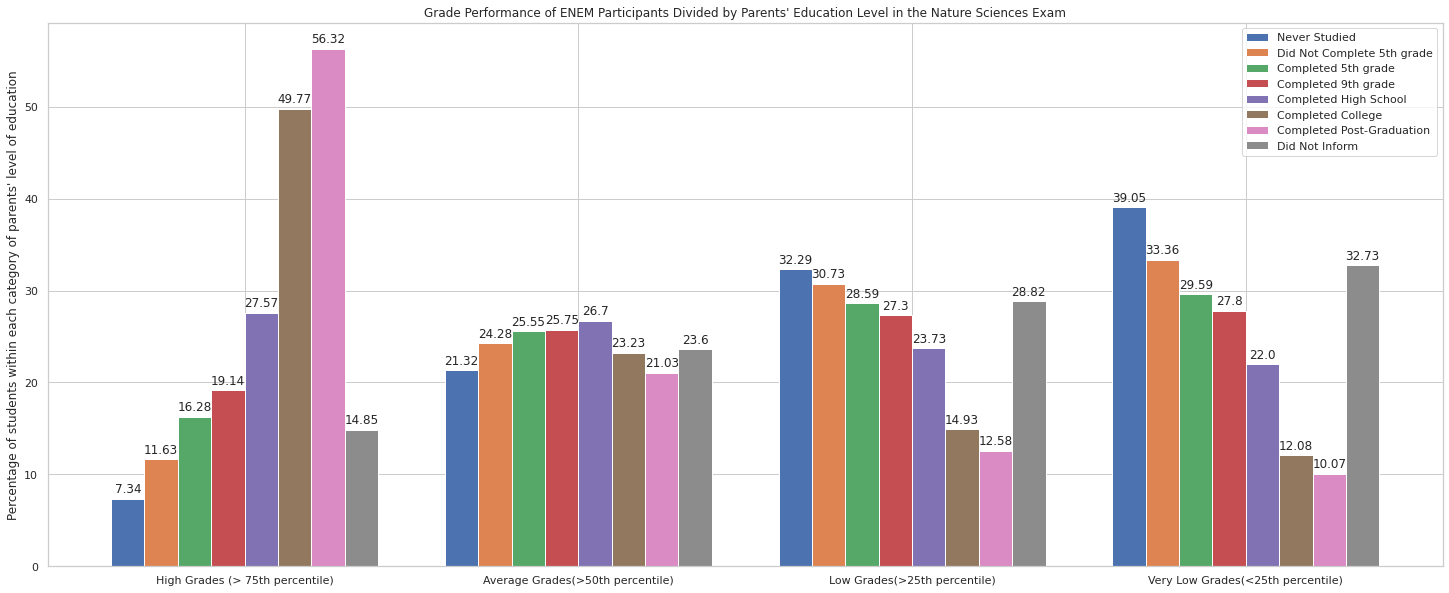

In [70]:
# Nature Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1.5*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_a = ax.bar(x - 3.5 * width, ed_lvl_data['A']['NU_NOTA_CN'], width, label='Never Studied')
rects_b = ax.bar(x - 2.5 * width, ed_lvl_data['B']['NU_NOTA_CN'], width, label='Did Not Complete 5th grade')
rects_c = ax.bar(x - 1.5 * width, ed_lvl_data['C']['NU_NOTA_CN'], width, label='Completed 5th grade')
rects_d = ax.bar(x - 0.5 * width, ed_lvl_data['D']['NU_NOTA_CN'], width, label='Completed 9th grade')
rects_e = ax.bar(x + 0.5 * width, ed_lvl_data['E']['NU_NOTA_CN'], width, label='Completed High School')
rects_f = ax.bar(x + 1.5 * width, ed_lvl_data['F']['NU_NOTA_CN'], width, label='Completed College')
rects_g = ax.bar(x + 2.5 * width, ed_lvl_data['G']['NU_NOTA_CN'], width, label='Completed Post-Graduation')
rects_h = ax.bar(x + 3.5 * width, ed_lvl_data['H']['NU_NOTA_CN'], width, label='Did Not Inform')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel("Percentage of students within each category of parents' level of education")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_a)
autolabel(rects_b)
autolabel(rects_c)
autolabel(rects_d)
autolabel(rects_e)
autolabel(rects_f)
autolabel(rects_g)
autolabel(rects_h)


plt.title("Grade Performance of ENEM Participants Divided by Parents' Education Level in the Nature Sciences Exam")

Text(0.5, 1.0, "Grade Performance of ENEM Participants Divided by Parents' Education Level in the Essay Exam")

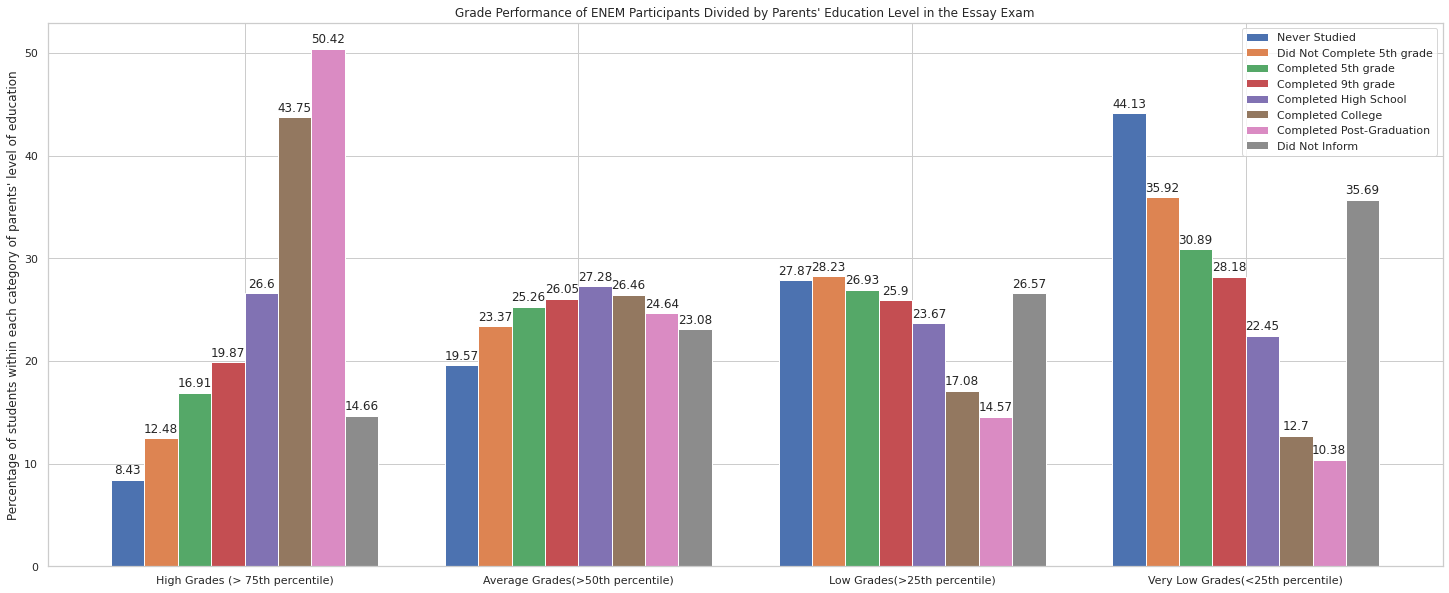

In [69]:
# Essay Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
# sns.set_theme()
sns.set_style("whitegrid")

x = 1.5*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_a = ax.bar(x - 3.5 * width, ed_lvl_data['A']['NU_NOTA_REDACAO'], width, label='Never Studied')
rects_b = ax.bar(x - 2.5 * width, ed_lvl_data['B']['NU_NOTA_REDACAO'], width, label='Did Not Complete 5th grade')
rects_c = ax.bar(x - 1.5 * width, ed_lvl_data['C']['NU_NOTA_REDACAO'], width, label='Completed 5th grade')
rects_d = ax.bar(x - 0.5 * width, ed_lvl_data['D']['NU_NOTA_REDACAO'], width, label='Completed 9th grade')
rects_e = ax.bar(x + 0.5 * width, ed_lvl_data['E']['NU_NOTA_REDACAO'], width, label='Completed High School')
rects_f = ax.bar(x + 1.5 * width, ed_lvl_data['F']['NU_NOTA_REDACAO'], width, label='Completed College')
rects_g = ax.bar(x + 2.5 * width, ed_lvl_data['G']['NU_NOTA_REDACAO'], width, label='Completed Post-Graduation')
rects_h = ax.bar(x + 3.5 * width, ed_lvl_data['H']['NU_NOTA_REDACAO'], width, label='Did Not Inform')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel("Percentage of students within each category of parents' level of education")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_a)
autolabel(rects_b)
autolabel(rects_c)
autolabel(rects_d)
autolabel(rects_e)
autolabel(rects_f)
autolabel(rects_g)
autolabel(rects_h)


plt.title("Grade Performance of ENEM Participants Divided by Parents' Education Level in the Essay Exam")

#### Hypothesis 3 - Summary

Key points to be highlighted after analyzing the plots for Hypothesis 3:

- Like Hypothesis 2, Hypothesis 3 is confirmed for all subjects, especially at extremes grades.
- Average grades usually serve as transition where the percentages of students from different categories converge. What differs between categories is the trend: while students with parents with higher levels of education tend are reducing in lower grades, the opposite happens to students which parents do not have the same education background.
- Throughout all subjects, students that did not respond to the survey usually have concentration percentages close to students whose parents did not complete the 5th grade.
- Finally, given the well-difined shapes of the plots, the features used for checking this hypothesis are really useful in creating a grade prediction model.

### Hypotheses Checking - Hypothesis 4

Hypothesis 4 states that:

*Students with a greater monthly house income have better grades.*

This hypothesis can be checked using only the feature Q006, that asks students about their monthly familiar income.



In [47]:
print('Number of different subcategories under monthly familiar income:')
print(len(df_train['Q006'].unique()))

Number of different subcategories under monthly familiar income:
17


Given the number of income range divisions present in this feature, some of them will be merged together in order to result into 4 income categories:

- Very high income: More than 19.960 BRL

- High income: Between 9.980 BRL and 19.960 BRL

- Average income: Bewtween 4.990 BRL and 9.980 BRL

- Low income: Less than 4.490 BRL

In [48]:
# Creating lists with feature variables for defined income ranges:
vh_i = ['Q']
hi_i = ['N', 'O', 'P']
av_i = ['I', 'J', 'K', 'L', 'M']
lo_i = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
income_ranges = {'VH_I': vh_i, 'HI_I': hi_i, 'AV_I': av_i, 'LO_I': lo_i}

Having these lists, I will continue to the hypothesis checking through plot analysis.

#### Hypothesis 4 - Visualization

In [49]:
# Creating the dictionaries to hold the percentages of students in each grade range
hg_in = defaultdict(dict) # High Grades
ag_in = defaultdict(dict) # Average Grades
lg_in = defaultdict(dict) # Low Grades
vg_in = defaultdict(dict) # Very Low Grades

# Students divided by grade performance in all subjects and parents' education level:
for income_tag, income_list in income_ranges.items():
    for grade in targets:
        # fathers_only = df_train[df_train['Q001'] == lvl] # Students with fathers on det. ed. level
        # mothers_only = df_train[df_train['Q002'] == lvl] # Students with mothers on det. ed. level
        # fathers_mothers = df_train[(df_train['Q001'] == lvl) & (df_train['Q002'] == lvl)] # Students with fathers and monthers on det. ed. level
        total = df_train[df_train['Q006'].isin(income_list)].shape[0]

        # Getting the percentages of students in each grade category:
        hg_in[income_tag][grade] = df_train[(df_train['Q006'].isin(income_list)) & (df_train[grade] > perc[grade][2])].shape[0] / total

        ag_in[income_tag][grade] = df_train[(df_train['Q006'].isin(income_list)) & ((df_train[grade] <= perc[grade][2]) & (df_train[grade] > perc[grade][1]))].shape[0] / total

        lg_in[income_tag][grade] = df_train[(df_train['Q006'].isin(income_list)) & ((df_train[grade] <= perc[grade][1]) & (df_train[grade] > perc[grade][0]))].shape[0] / total

        vg_in[income_tag][grade] = df_train[(df_train['Q006'].isin(income_list)) & (df_train[grade] < perc[grade][0])].shape[0] / total

In [50]:
# Creation of income data dictionary:        
income_data = defaultdict(dict)

# Creation of plot heights:
for income_tag, income_list in income_ranges.items():
    for grade in targets:
        income_data[income_tag][grade] = [ round(hg_in[income_tag][grade] * 100, 2), round(ag_in[income_tag][grade] * 100, 2),
                                          round(lg_in[income_tag][grade] * 100, 2), round(vg_in[income_tag][grade] * 100, 2) ] 

income_data

defaultdict(dict,
            {'AV_I': {'NU_NOTA_CH': [52.94, 24.38, 13.54, 9.13],
              'NU_NOTA_CN': [54.43, 23.51, 12.88, 9.15],
              'NU_NOTA_LC': [52.96, 25.66, 13.32, 8.04],
              'NU_NOTA_MT': [54.84, 23.87, 13.1, 8.18],
              'NU_NOTA_REDACAO': [46.92, 26.74, 16.02, 8.51]},
             'HI_I': {'NU_NOTA_CH': [66.61, 19.29, 8.65, 5.44],
              'NU_NOTA_CN': [68.99, 17.95, 7.83, 5.23],
              'NU_NOTA_LC': [66.52, 20.7, 8.09, 4.68],
              'NU_NOTA_MT': [69.82, 17.88, 7.83, 4.46],
              'NU_NOTA_REDACAO': [58.76, 23.82, 11.48, 4.77]},
             'LO_I': {'NU_NOTA_CH': [19.81, 25.45, 27.08, 27.61],
              'NU_NOTA_CN': [19.57, 25.58, 27.16, 27.64],
              'NU_NOTA_LC': [19.79, 25.23, 27.15, 27.78],
              'NU_NOTA_MT': [19.44, 25.56, 27.16, 27.79],
              'NU_NOTA_REDACAO': [19.81, 25.48, 25.79, 24.98]},
             'VH_I': {'NU_NOTA_CH': [73.85, 15.22, 6.5, 4.41],
              'NU_NOTA_

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Family Income Range in the Math Exam')

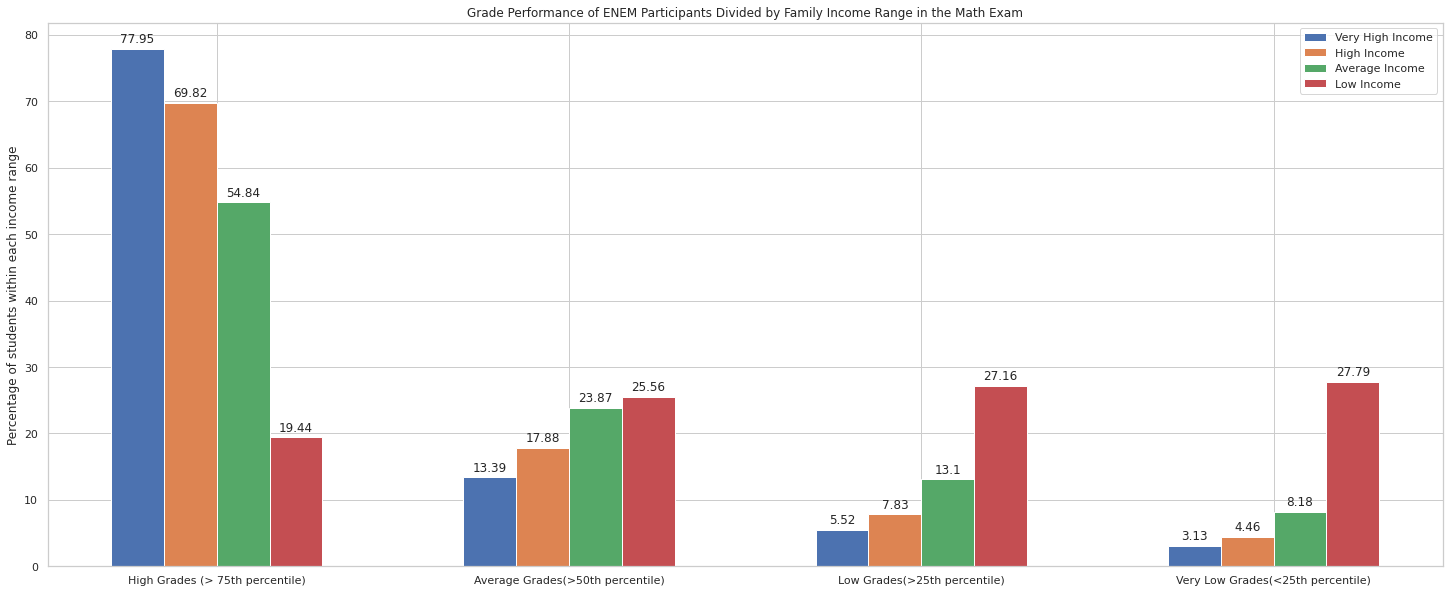

In [74]:
# Math Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_vh_i = ax.bar(x - 1.5 * width, income_data['VH_I']['NU_NOTA_MT'], width, label='Very High Income')
rects_hi_i = ax.bar(x - 0.5 * width, income_data['HI_I']['NU_NOTA_MT'], width, label='High Income')
rects_av_i = ax.bar(x + 0.5 * width, income_data['AV_I']['NU_NOTA_MT'], width, label='Average Income')
rects_lo_i = ax.bar(x + 1.5 * width, income_data['LO_I']['NU_NOTA_MT'], width, label='Low Income')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each income range')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_vh_i)
autolabel(rects_hi_i)
autolabel(rects_av_i)
autolabel(rects_lo_i)



plt.title("Grade Performance of ENEM Participants Divided by Family Income Range in the Math Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Family Income Range in the Languages Exam')

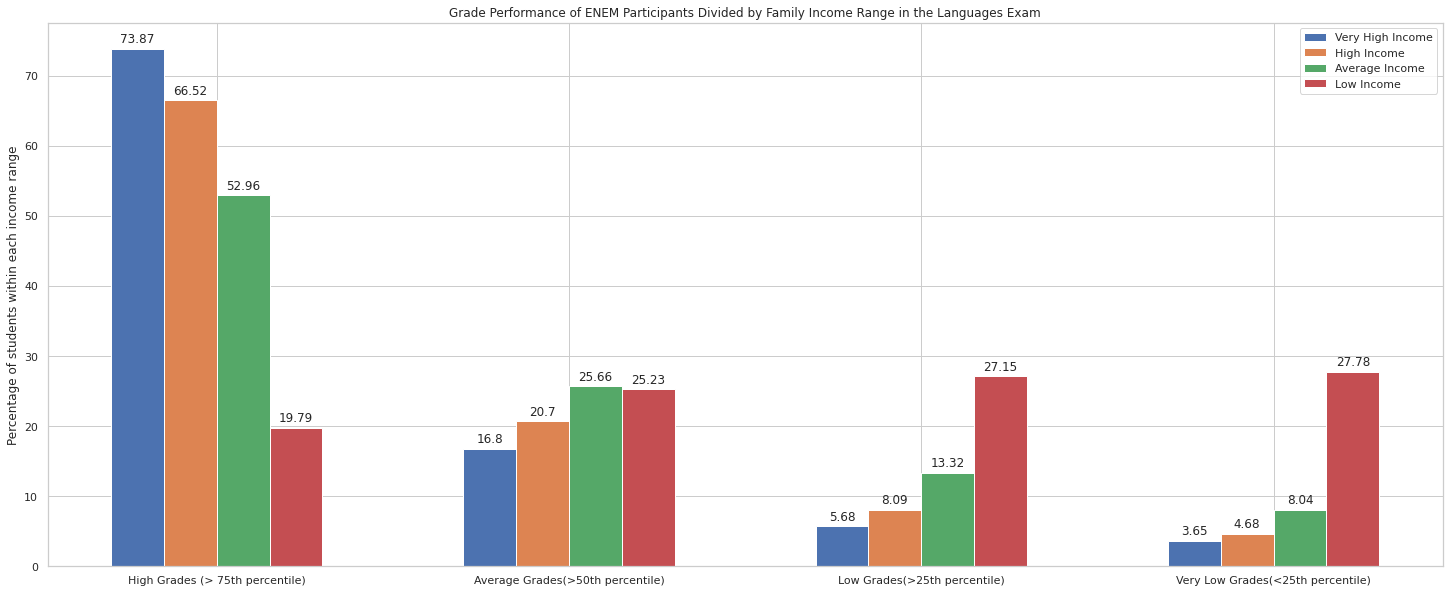

In [75]:
# Languages Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_vh_i = ax.bar(x - 1.5 * width, income_data['VH_I']['NU_NOTA_LC'], width, label='Very High Income')
rects_hi_i = ax.bar(x - 0.5 * width, income_data['HI_I']['NU_NOTA_LC'], width, label='High Income')
rects_av_i = ax.bar(x + 0.5 * width, income_data['AV_I']['NU_NOTA_LC'], width, label='Average Income')
rects_lo_i = ax.bar(x + 1.5 * width, income_data['LO_I']['NU_NOTA_LC'], width, label='Low Income')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each income range')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_vh_i)
autolabel(rects_hi_i)
autolabel(rects_av_i)
autolabel(rects_lo_i)



plt.title("Grade Performance of ENEM Participants Divided by Family Income Range in the Languages Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Family Income Range in the Human Sciences Exam')

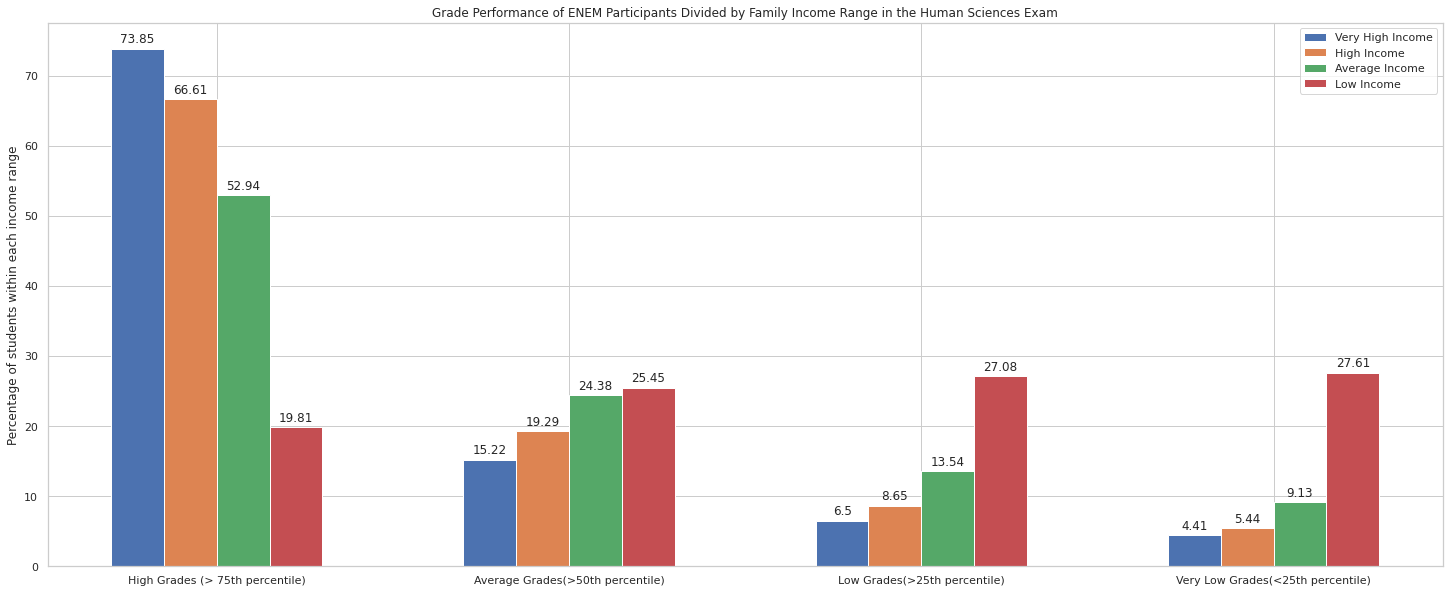

In [76]:
# Human Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_vh_i = ax.bar(x - 1.5 * width, income_data['VH_I']['NU_NOTA_CH'], width, label='Very High Income')
rects_hi_i = ax.bar(x - 0.5 * width, income_data['HI_I']['NU_NOTA_CH'], width, label='High Income')
rects_av_i = ax.bar(x + 0.5 * width, income_data['AV_I']['NU_NOTA_CH'], width, label='Average Income')
rects_lo_i = ax.bar(x + 1.5 * width, income_data['LO_I']['NU_NOTA_CH'], width, label='Low Income')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each income range')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_vh_i)
autolabel(rects_hi_i)
autolabel(rects_av_i)
autolabel(rects_lo_i)



plt.title("Grade Performance of ENEM Participants Divided by Family Income Range in the Human Sciences Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Family Income Range in the Nature Sciences Exam')

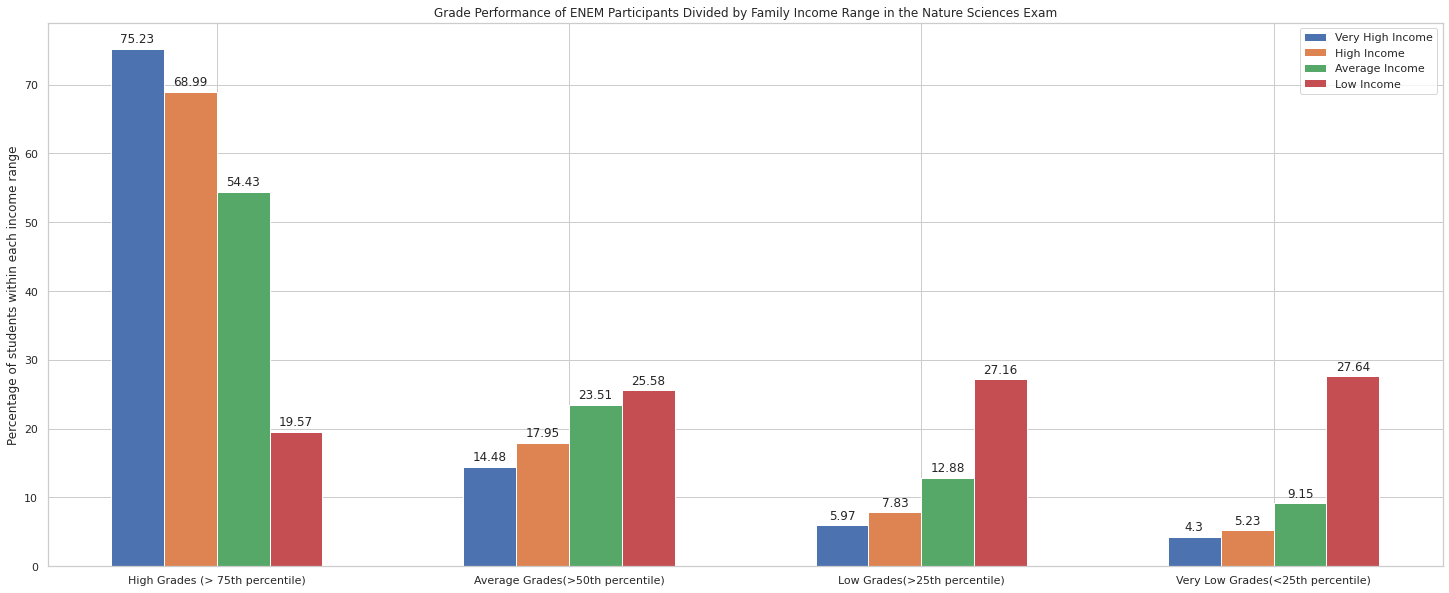

In [77]:
# Nature Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_vh_i = ax.bar(x - 1.5 * width, income_data['VH_I']['NU_NOTA_CN'], width, label='Very High Income')
rects_hi_i = ax.bar(x - 0.5 * width, income_data['HI_I']['NU_NOTA_CN'], width, label='High Income')
rects_av_i = ax.bar(x + 0.5 * width, income_data['AV_I']['NU_NOTA_CN'], width, label='Average Income')
rects_lo_i = ax.bar(x + 1.5 * width, income_data['LO_I']['NU_NOTA_CN'], width, label='Low Income')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each income range')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_vh_i)
autolabel(rects_hi_i)
autolabel(rects_av_i)
autolabel(rects_lo_i)



plt.title("Grade Performance of ENEM Participants Divided by Family Income Range in the Nature Sciences Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Family Income Range in the Essay Exam')

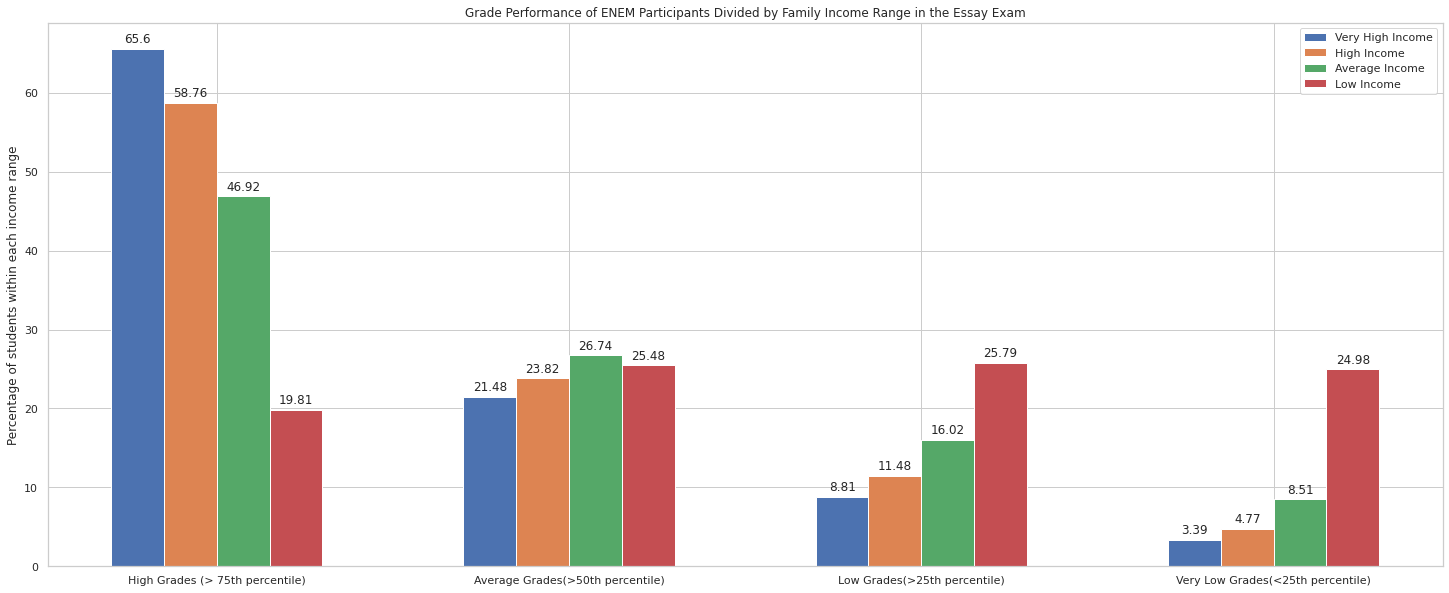

In [78]:
# Essay Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_vh_i = ax.bar(x - 1.5 * width, income_data['VH_I']['NU_NOTA_REDACAO'], width, label='Very High Income')
rects_hi_i = ax.bar(x - 0.5 * width, income_data['HI_I']['NU_NOTA_REDACAO'], width, label='High Income')
rects_av_i = ax.bar(x + 0.5 * width, income_data['AV_I']['NU_NOTA_REDACAO'], width, label='Average Income')
rects_lo_i = ax.bar(x + 1.5 * width, income_data['LO_I']['NU_NOTA_REDACAO'], width, label='Low Income')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each income range')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_vh_i)
autolabel(rects_hi_i)
autolabel(rects_av_i)
autolabel(rects_lo_i)



plt.title("Grade Performance of ENEM Participants Divided by Family Income Range in the Essay Exam")

#### Hypothesis 4 - Summary

- The main proposition oh the hypothesis was confirmed given the performance disparity between students with both high and very high income (these two categories are fairly close in all grade ranges) when compared to the students with low income.
- There was not a clear differentiation between the percentages of low income students for average, low and very low grade ranges (for high grades, the percentage concentrarion is smaller, but not by much). This could mean that this feature would have a smaller importance on predicting the grades for students in this category.

### Hypotheses Checking - Hypothesis 5

Hypothesis 5 states that:

*Internet access is a big factor on the definition of students' grades*

First of all, nowadays internet is already considered a basic need. Therefore the idea that someone does not have internet access in 2022 can be absurd for some people. But since Brazil has extremely poor areas, initially I will check the percentage of students that do not have access to internet in any way.

The check of this hypothesis will be done using feature Q025 (existence of internet access in the student's house) and featuer Q022 (the number of cell phones in the student's house). 

Obs: I will consider that having a cell phone means having a internet connection. This is based on the knowledge that in poor areas of Brazil most families do not have access to a traditional internet connection and use most online services through 3G or 4G mobile connections.

The categories for internet access will be:

In [56]:
# Percentage of students without any internet connection:
no_internet = df_train[(df_train['Q025'] == 'A') & (df_train['Q022'] == 'A')]
p_no_internet = no_internet.shape[0] / df_train.shape[0]

print(f'Percentage of students without any kind of internet connection: {round(p_no_internet * 100, 2)} %.')

# Percentage of students that only have internet connection through cell phones:
just_phone = df_train[(df_train['Q025'] == 'A') & (df_train['Q022'] != 'A')]
p_just_phone = just_phone.shape[0] / df_train.shape[0]

print(f'Percentage of students that use connect to the internet only via cell phones : {round(p_just_phone * 100, 2)} %.')

# Percentage of students that have a tradicional internet connection regardless of cell phone:
internet = df_train[(df_train['Q025'] == 'B')]
p_internet = internet.shape[0] / df_train.shape[0]

print(f'Percentage of students that have a regular internet connection : {round(p_internet * 100, 2)} %.')

# Percentage of students that have a tradicional internet connection and more than 2 cell phones in the house:
internet_phone = df_train[(df_train['Q025'] == 'B') & ((df_train['Q022'] == 'D') | (df_train['Q022'] == 'E'))]
p_internet_phone = internet_phone.shape[0] / df_train.shape[0]

print(f'Percentage of students that have a regular internet connection and three or more cell phones at the house: {round(p_internet_phone * 100, 2)} %.')

Percentage of students without any kind of internet connection: 1.07 %.
Percentage of students that use connect to the internet only via cell phones : 19.66 %.
Percentage of students that have a regular internet connection : 79.27 %.
Percentage of students that have a regular internet connection and three or more cell phones at the house: 45.14 %.


I chose to continue with the category "no internet connection of any kind" despite its low percentage because 1.07% of the entire dataset corresponds to 25.096 students, which can be revealing of some aspect of the grade distribution.

#### Hypothesis 5 - Visualization

In [57]:
# Creating dict for levels of internet access:
internet_ranges = {0: no_internet , 1: just_phone, 2: internet, 3: internet_phone}

# Creating the dictionaries to hold the percentages of students in each grade range
hg_int = defaultdict(dict) # High Grade Students percentages divided by level of internet access
ag_int = defaultdict(dict) # Average Grade Students percentages divided by level of internet access
lg_int = defaultdict(dict) # Low Grade Students percentages divided by level of internet access
vg_int = defaultdict(dict) # Very Low Grade Students percentages divided by level of internet access

# Students divided by grade performance in all subjects and internet access level:
for grade in targets:
    for i_range_tag, df_i_range in internet_ranges.items():
        total = df_i_range.shape[0]

        hg_int[i_range_tag][grade] = df_i_range[df_i_range[grade] > perc[grade][2]].shape[0] / total

        ag_int[i_range_tag][grade] = df_i_range[(df_i_range[grade] <= perc[grade][2]) & (df_i_range[grade] > perc[grade][1])].shape[0] / total

        lg_int[i_range_tag][grade] = df_i_range[(df_i_range[grade] <= perc[grade][1]) & (df_i_range[grade] > perc[grade][0])].shape[0] / total

        vg_int[i_range_tag][grade] = df_i_range[(df_i_range[grade] < perc[grade][0])].shape[0] / total

In [58]:
# Creation of income data dictionary:        
internet_data = defaultdict(dict)

# Creation of plot heights:
for i_range_tag, df_i_range in internet_ranges.items():
    for grade in targets:
        internet_data[i_range_tag][grade] = [ round(hg_int[i_range_tag][grade] * 100, 2), round(ag_int[i_range_tag][grade] * 100, 2),
                                          round(lg_int[i_range_tag][grade] * 100, 2), round(vg_int[i_range_tag][grade] * 100, 2) ] 

internet_data

defaultdict(dict,
            {0: {'NU_NOTA_CH': [6.97, 16.9, 30.69, 45.36],
              'NU_NOTA_CN': [6.81, 18.29, 30.71, 44.12],
              'NU_NOTA_LC': [6.14, 14.74, 27.69, 51.38],
              'NU_NOTA_MT': [6.46, 18.67, 31.41, 43.38],
              'NU_NOTA_REDACAO': [10.38, 19.59, 26.31, 38.83]},
             1: {'NU_NOTA_CH': [9.9, 21.3, 30.72, 38.03],
              'NU_NOTA_CN': [9.56, 22.47, 31.16, 36.74],
              'NU_NOTA_LC': [9.23, 20.05, 30.17, 40.48],
              'NU_NOTA_MT': [9.11, 22.02, 31.13, 37.68],
              'NU_NOTA_REDACAO': [11.87, 22.84, 27.75, 32.85]},
             2: {'NU_NOTA_CH': [28.95, 26.04, 23.53, 21.45],
              'NU_NOTA_CN': [29.07, 25.7, 23.38, 21.8],
              'NU_NOTA_LC': [29.11, 26.36, 23.71, 20.78],
              'NU_NOTA_MT': [29.17, 25.81, 23.41, 21.58],
              'NU_NOTA_REDACAO': [27.29, 26.21, 23.33, 19.83]},
             3: {'NU_NOTA_CH': [34.22, 26.47, 21.42, 17.86],
              'NU_NOTA_CN': [34.88, 2

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Internet Levels in the Math Exam')

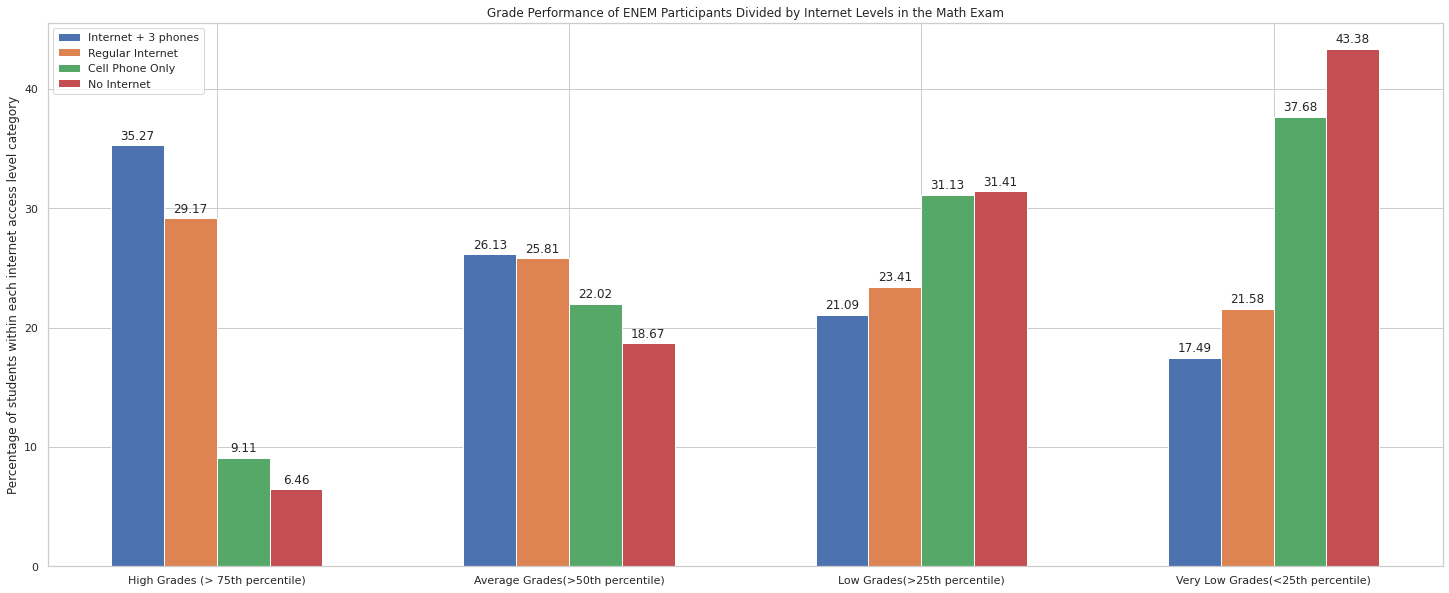

In [59]:
# Math Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_int_3 = ax.bar(x - 1.5 * width, internet_data[3]['NU_NOTA_MT'], width, label='Internet + 3 phones')
rects_int_2 = ax.bar(x - 0.5 * width, internet_data[2]['NU_NOTA_MT'], width, label='Regular Internet')
rects_int_1 = ax.bar(x + 0.5 * width, internet_data[1]['NU_NOTA_MT'], width, label='Cell Phone Only')
rects_int_0 = ax.bar(x + 1.5 * width, internet_data[0]['NU_NOTA_MT'], width, label='No Internet')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each internet access level category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_int_3)
autolabel(rects_int_2)
autolabel(rects_int_1)
autolabel(rects_int_0)

plt.title("Grade Performance of ENEM Participants Divided by Internet Levels in the Math Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Internet Levels in the Languages Exam')

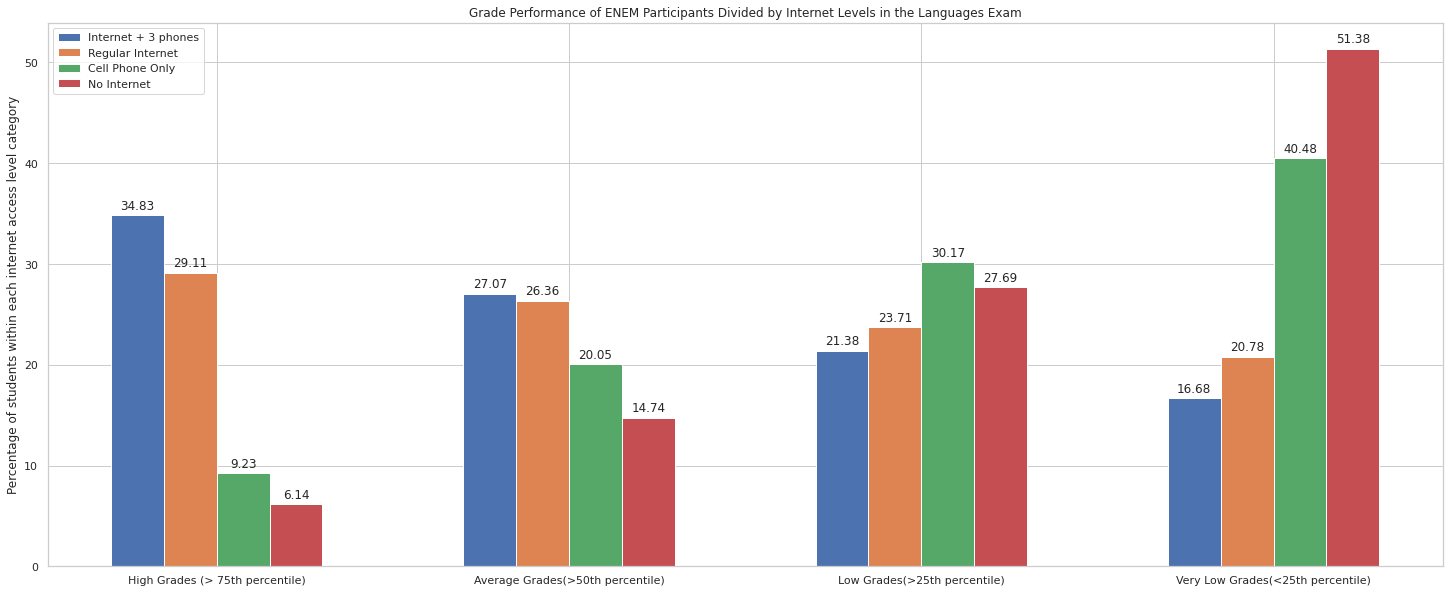

In [60]:
# Languages Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_int_3 = ax.bar(x - 1.5 * width, internet_data[3]['NU_NOTA_LC'], width, label='Internet + 3 phones')
rects_int_2 = ax.bar(x - 0.5 * width, internet_data[2]['NU_NOTA_LC'], width, label='Regular Internet')
rects_int_1 = ax.bar(x + 0.5 * width, internet_data[1]['NU_NOTA_LC'], width, label='Cell Phone Only')
rects_int_0 = ax.bar(x + 1.5 * width, internet_data[0]['NU_NOTA_LC'], width, label='No Internet')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each internet access level category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_int_3)
autolabel(rects_int_2)
autolabel(rects_int_1)
autolabel(rects_int_0)

plt.title("Grade Performance of ENEM Participants Divided by Internet Levels in the Languages Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Internet Levels in the Human Sciences Exam')

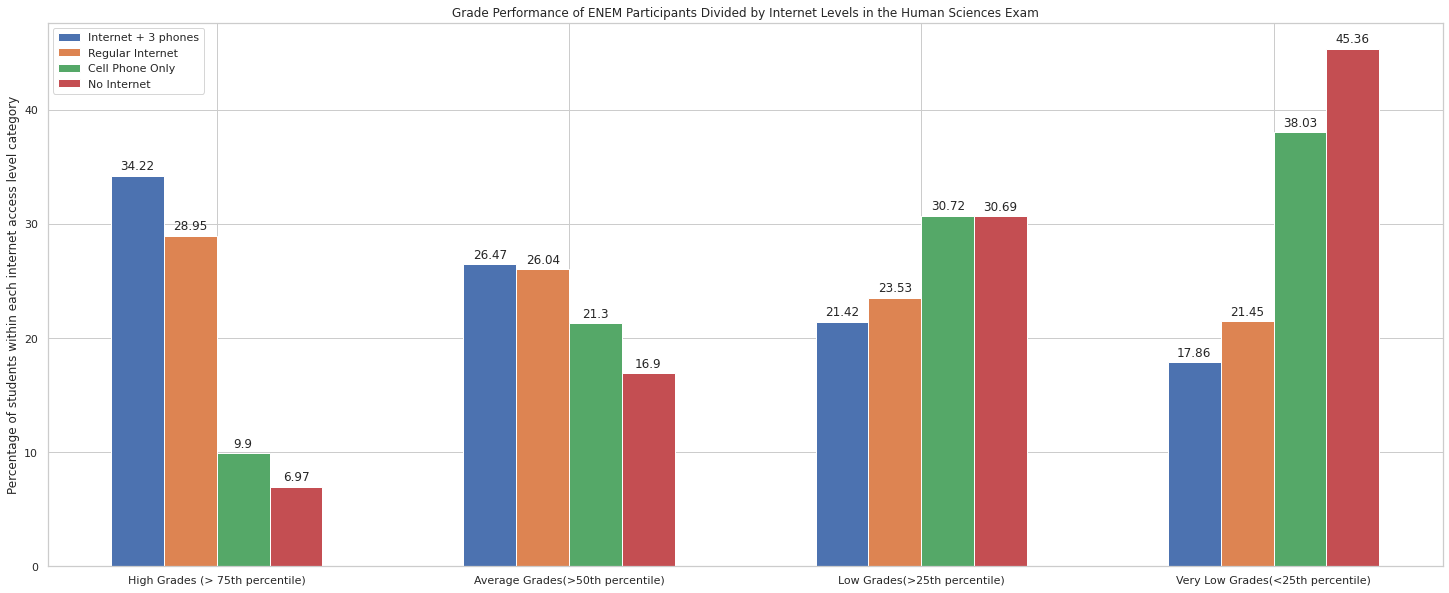

In [61]:
# Human Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_int_3 = ax.bar(x - 1.5 * width, internet_data[3]['NU_NOTA_CH'], width, label='Internet + 3 phones')
rects_int_2 = ax.bar(x - 0.5 * width, internet_data[2]['NU_NOTA_CH'], width, label='Regular Internet')
rects_int_1 = ax.bar(x + 0.5 * width, internet_data[1]['NU_NOTA_CH'], width, label='Cell Phone Only')
rects_int_0 = ax.bar(x + 1.5 * width, internet_data[0]['NU_NOTA_CH'], width, label='No Internet')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each internet access level category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_int_3)
autolabel(rects_int_2)
autolabel(rects_int_1)
autolabel(rects_int_0)

plt.title("Grade Performance of ENEM Participants Divided by Internet Levels in the Human Sciences Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Internet Levels in the Nature Sciences Exam')

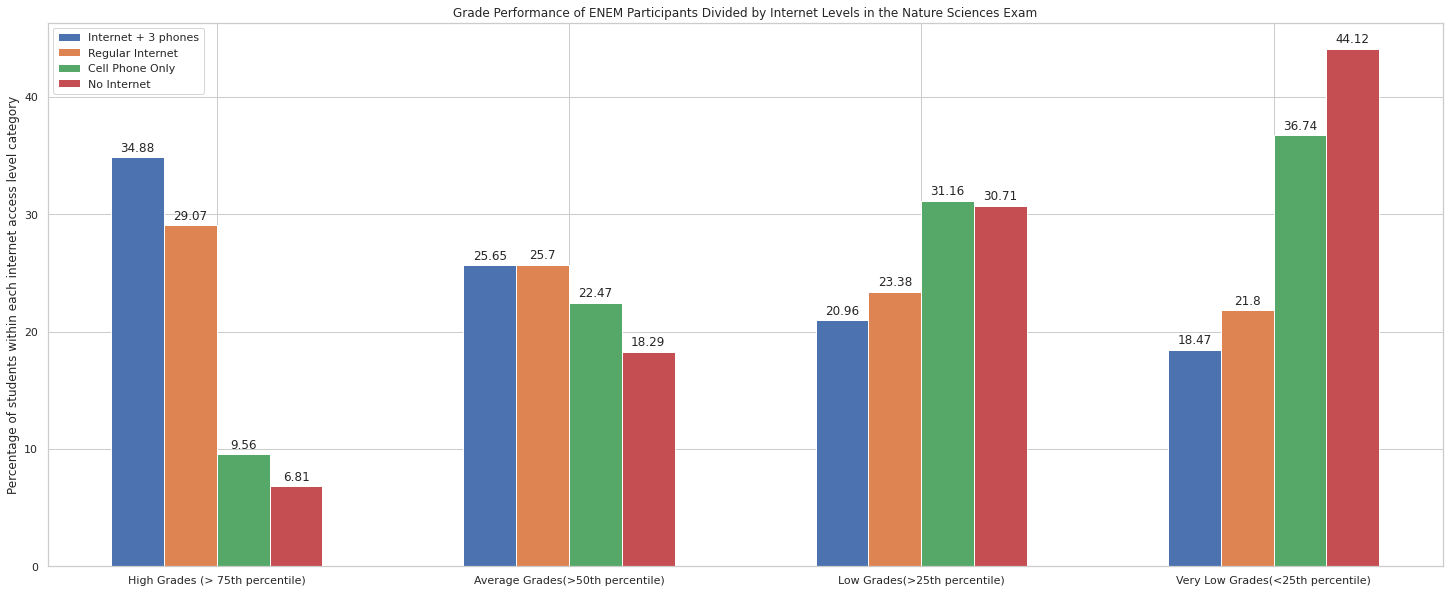

In [62]:
# Nature Sciences Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_int_3 = ax.bar(x - 1.5 * width, internet_data[3]['NU_NOTA_CN'], width, label='Internet + 3 phones')
rects_int_2 = ax.bar(x - 0.5 * width, internet_data[2]['NU_NOTA_CN'], width, label='Regular Internet')
rects_int_1 = ax.bar(x + 0.5 * width, internet_data[1]['NU_NOTA_CN'], width, label='Cell Phone Only')
rects_int_0 = ax.bar(x + 1.5 * width, internet_data[0]['NU_NOTA_CN'], width, label='No Internet')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each internet access level category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_int_3)
autolabel(rects_int_2)
autolabel(rects_int_1)
autolabel(rects_int_0)

plt.title("Grade Performance of ENEM Participants Divided by Internet Levels in the Nature Sciences Exam")

Text(0.5, 1.0, 'Grade Performance of ENEM Participants Divided by Internet Levels in the Essay Exam')

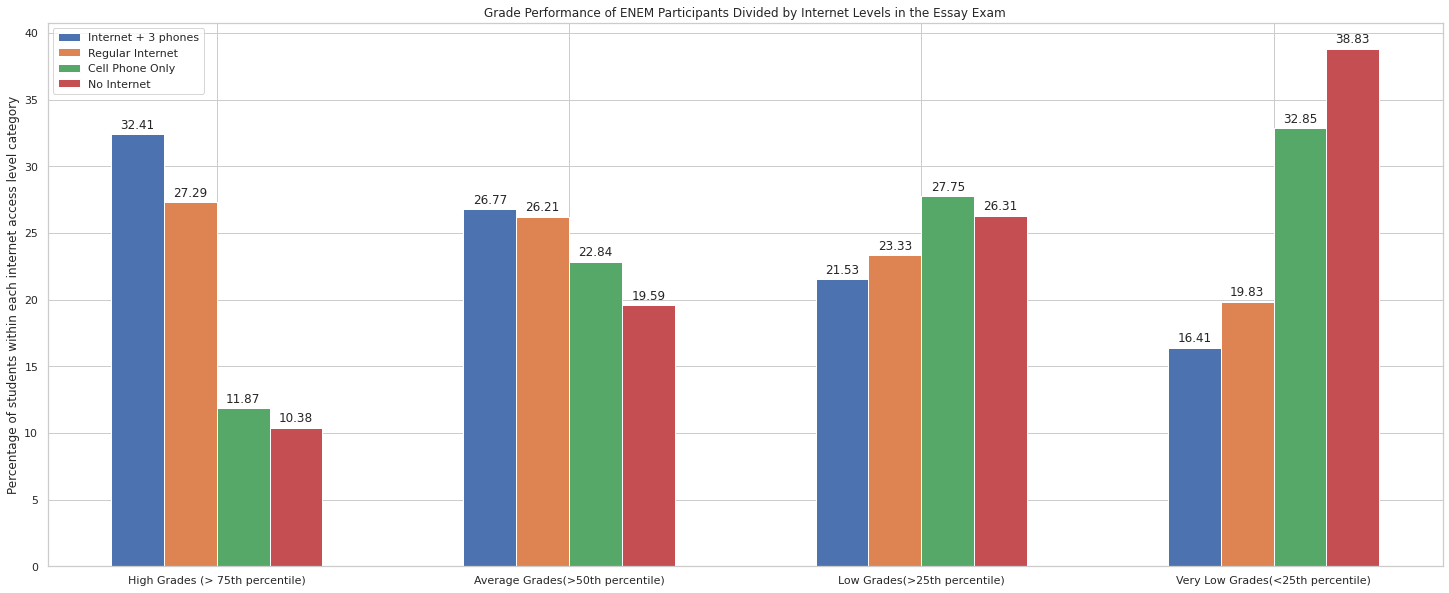

In [63]:
# Essay Plot:
labels = ['High Grades (> 75th percentile)', 'Average Grades(>50th percentile)', 'Low Grades(>25th percentile)', 'Very Low Grades(<25th percentile)']
sns.set_theme()
sns.set_style("whitegrid")

x = 1*np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))

rects_int_3 = ax.bar(x - 1.5 * width, internet_data[3]['NU_NOTA_REDACAO'], width, label='Internet + 3 phones')
rects_int_2 = ax.bar(x - 0.5 * width, internet_data[2]['NU_NOTA_REDACAO'], width, label='Regular Internet')
rects_int_1 = ax.bar(x + 0.5 * width, internet_data[1]['NU_NOTA_REDACAO'], width, label='Cell Phone Only')
rects_int_0 = ax.bar(x + 1.5 * width, internet_data[0]['NU_NOTA_REDACAO'], width, label='No Internet')

ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(labels)
ax.legend()
plt.ylabel('Percentage of students within each internet access level category')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects_int_3)
autolabel(rects_int_2)
autolabel(rects_int_1)
autolabel(rects_int_0)

plt.title("Grade Performance of ENEM Participants Divided by Internet Levels in the Essay Exam")

#### Hypothesis 5 - Summary

- There is a clear differentition in the extreme grade ranges between students that have regular internet and students that either connect to the internet only through cell phones or do not have access to it at all.
- In the average and low grade ranges, the concentration of percentages have values that reflect the hypothesis but in a much more discrete pattern.
- The difference between the categories that have regular access to the internet can be seen as result of the income influence, since the "Internet + 3 phones" is a wealthier subset of the "regular internet" category.
- There is not a considerable distance between the student concentrations in the "Cell Phone Only" and "No Internet" categories for all grade ranges except in very low grades. 
- These two last findings are evidence that the feature that holds information about cell phones is already taken into consideration when the monthly family income feature is used in the training of a grade prediction model.

### Specialized Health Care Information Features (SHCI):

In [ ]:
# Creating list with SHCI features:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('IN_BAIXA_VISAO')
last_index = df_train.columns.get_loc('IN_OUTRA_DEF')
shci_index = list(range(first_index, last_index + 1))
shci_index.append(df_train.columns.get_loc(tag_col))
shci_index = sorted(shci_index)
shci = list(df_train.columns[shci_index])

# Printing SHCI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features related to specialized health care students might need are:\n")
pp.pprint(shci)
print("\nNumber of features in this section:")
print(len(shci))

The features related to specialized health care students might need are:

[   'NU_INSCRICAO',
    'IN_BAIXA_VISAO',
    'IN_CEGUEIRA',
    'IN_SURDEZ',
    'IN_DEFICIENCIA_AUDITIVA',
    'IN_SURDO_CEGUEIRA',
    'IN_DEFICIENCIA_FISICA',
    'IN_DEFICIENCIA_MENTAL',
    'IN_DEFICIT_ATENCAO',
    'IN_DISLEXIA',
    'IN_DISCALCULIA',
    'IN_AUTISMO',
    'IN_VISAO_MONOCULAR',
    'IN_OUTRA_DEF']

Number of features in this section:
14


In [ ]:
df_shci = df_train[shci+targets]

In [ ]:
rows = []
cols = []
for col in df_shci[shci].columns:
    if col != tag_col:
        for var in df_shci[col].unique():
            print(os.path.join(col, str(var)))

IN_BAIXA_VISAO/0
IN_BAIXA_VISAO/1
IN_CEGUEIRA/0
IN_CEGUEIRA/1
IN_SURDEZ/0
IN_SURDEZ/1
IN_DEFICIENCIA_AUDITIVA/0
IN_DEFICIENCIA_AUDITIVA/1
IN_SURDO_CEGUEIRA/0
IN_SURDO_CEGUEIRA/1
IN_DEFICIENCIA_FISICA/0
IN_DEFICIENCIA_FISICA/1
IN_DEFICIENCIA_MENTAL/0
IN_DEFICIENCIA_MENTAL/1
IN_DEFICIT_ATENCAO/0
IN_DEFICIT_ATENCAO/1
IN_DISLEXIA/0
IN_DISLEXIA/1
IN_DISCALCULIA/0
IN_DISCALCULIA/1
IN_AUTISMO/0
IN_AUTISMO/1
IN_VISAO_MONOCULAR/0
IN_VISAO_MONOCULAR/1
IN_OUTRA_DEF/0
IN_OUTRA_DEF/1


NU_NOTA_CN          242
NU_NOTA_REDACAO       0
NU_NOTA_MT          315
NU_NOTA_CH         1281
NU_NOTA_LC          580
dtype: int64

### Specific Care Information Features (SCI):

In [ ]:
# Creating list with SCI features:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('IN_GESTANTE')
last_index = df_train.columns.get_loc('IN_ESTUDA_CLASSE_HOSPITALAR')
sci_index = list(range(first_index, last_index + 1))
sci_index.append(df_train.columns.get_loc(tag_col))
sci_index = sorted(sci_index)
sci = list(df_train.columns[sci_index])

# Printing SCI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features related to specific cares students might need are:\n")
pp.pprint(sci)
print("\nNumber of features in this section:")
print(len(sci))

The features related to specific cares students might need are:

[   'NU_INSCRICAO',
    'IN_GESTANTE',
    'IN_LACTANTE',
    'IN_IDOSO',
    'IN_ESTUDA_CLASSE_HOSPITALAR']

Number of features in this section:
5


### Specific Test Taking Needs Information Features (STTNI):

In [ ]:
# Creating list with STTNI features:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('IN_SEM_RECURSO')
last_index = df_train.columns.get_loc('IN_NOME_SOCIAL')
sttni_index = list(range(first_index, last_index + 1))
sttni_index.append(df_train.columns.get_loc(tag_col))
sttni_index = sorted(sttni_index)
sttni = list(df_train.columns[sttni_index])

# Printing STTNI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features concerning needs students might have when taking the test are:\n")
pp.pprint(sttni)
print("\nNumber of features in this section:")
print(len(sttni))

The features concerning needs students might have when taking the test are:

[   'NU_INSCRICAO',
    'IN_SEM_RECURSO',
    'IN_BRAILLE',
    'IN_AMPLIADA_24',
    'IN_AMPLIADA_18',
    'IN_LEDOR',
    'IN_ACESSO',
    'IN_TRANSCRICAO',
    'IN_LIBRAS',
    'IN_TEMPO_ADICIONAL',
    'IN_LEITURA_LABIAL',
    'IN_MESA_CADEIRA_RODAS',
    'IN_MESA_CADEIRA_SEPARADA',
    'IN_APOIO_PERNA',
    'IN_GUIA_INTERPRETE',
    'IN_COMPUTADOR',
    'IN_CADEIRA_ESPECIAL',
    'IN_CADEIRA_CANHOTO',
    'IN_CADEIRA_ACOLCHOADA',
    'IN_PROVA_DEITADO',
    'IN_MOBILIARIO_OBESO',
    'IN_LAMINA_OVERLAY',
    'IN_PROTETOR_AURICULAR',
    'IN_MEDIDOR_GLICOSE',
    'IN_MAQUINA_BRAILE',
    'IN_SOROBAN',
    'IN_MARCA_PASSO',
    'IN_SONDA',
    'IN_MEDICAMENTOS',
    'IN_SALA_INDIVIDUAL',
    'IN_SALA_ESPECIAL',
    'IN_SALA_ACOMPANHANTE',
    'IN_MOBILIARIO_ESPECIFICO',
    'IN_MATERIAL_ESPECIFICO',
    'IN_NOME_SOCIAL']

Number of features in this section:
35


### Objective Test Information Features (OTI):

In [ ]:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('TP_PRESENCA_CN')
last_index = df_train.columns.get_loc('TP_PRESENCA_MT')
add_feature_index = df_train.columns.get_loc('TP_LINGUA')
oti_index = list(range(first_index, last_index + 1))
oti_index.append(df_train.columns.get_loc(tag_col))
oti_index.append(add_feature_index)
oti_index = sorted(oti_index)
oti = list(df_train.columns[oti_index])

# Printing TSI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features concerning data about the objective section of the test are:\n")
pp.pprint(oti)
print("\nNumber of features in this section:")
print(len(oti))

The features concerning data about the objective section of the test are:

[   'NU_INSCRICAO',
    'TP_PRESENCA_CN',
    'TP_PRESENCA_CH',
    'TP_PRESENCA_LC',
    'TP_PRESENCA_MT',
    'TP_LINGUA']

Number of features in this section:
6


### Essay Information Features (EI):

In [ ]:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('TP_STATUS_REDACAO')
last_index = df_train.columns.get_loc('TP_STATUS_REDACAO')

ei_index = list(range(first_index, last_index + 1))
ei_index.append(df_train.columns.get_loc(tag_col))

ei_index = sorted(ei_index)
ei = list(df_train.columns[ei_index])

# Printing TSI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features concerning data about the test essay are:\n")
pp.pprint(ei)
print("\nNumber of features in this section:")
print(len(ei))

The features concerning data about the test essay are:

['NU_INSCRICAO', 'TP_STATUS_REDACAO']

Number of features in this section:
2


### Social-Economic Information Features (SEI):

In [ ]:
tag_col = 'NU_INSCRICAO'
first_index = df_train.columns.get_loc('Q001')
last_index = df_train.columns.get_loc('Q025')

sei_index = list(range(first_index, last_index + 1))
sei_index.append(df_train.columns.get_loc(tag_col))

sei_index = sorted(sei_index)
sei = list(df_train.columns[sei_index])

# Printing TSI features:
pp = pprint.PrettyPrinter(indent=4)
print("The features with information on social-economic survey about the students are:\n")
pp.pprint(sei)
print("\nNumber of features in this section:")
print(len(sei))

The features with information on social-economic survey about the students are:

[   'NU_INSCRICAO',
    'Q001',
    'Q002',
    'Q003',
    'Q004',
    'Q005',
    'Q006',
    'Q007',
    'Q008',
    'Q009',
    'Q010',
    'Q011',
    'Q012',
    'Q013',
    'Q014',
    'Q015',
    'Q016',
    'Q017',
    'Q018',
    'Q019',
    'Q020',
    'Q021',
    'Q022',
    'Q023',
    'Q024',
    'Q025']

Number of features in this section:
26


In [ ]:
df_train[sei].shape

(2336933, 26)